#**SOHO DATA ANALYSIS**

##**A Brief introduction**

SOHO, is the Solar & Heliospheric Observatory, is a project of international collaboration beetween ESA and NASA, and it has the objective to study the Sun from its deep core to the outer corona and the solar wind.

SOHO moves around the Sun in step with the Earth, by slowly orbiting around the First Lagrangian
Point (L1), where the combined gravity of the Earth and Sun keep SOHO in an orbit locked to the
Earth-Sun line.

SOHO has 12 complementary instruments and for this workshop, we are going to focus in  the Charge, Element, and Isotope Analysis System or best known as CELIAS by its acronym. CELIAS continuously samples the solar wind and energetic ions of solar, interplanetary and
interstellar origin, as they sweep past SOHO. It analyses the density and composition of particles
present in this solar wind. It warns of incoming solar storms that could damage satellites in Earth
orbit.

In [ ]:
"""
 SOHO/CELIAS/MTOF Proton Monitor
                    Solar Wind Parameters from PMSW 8.0b5

 -------------------------------------------------------------------------------------------------

 Listed Parameters:

 Measurement time (Year, Month, Day of Month, Day of Year, Hour, Minute, Second)
 Proton speed [km/sec]
 Proton density [protons per cubic centimeter]
 Most probable proton thermal speed [km/sec]
 Arrival direction [degrees from north-south, with + meaning FROM the south).
 V_He is the predicted (not measured) Helium speed
 (Vsw = -1 means NOT AVAILABLE)

 SOHO spacecraft coordinates: based on SOHO PRE orbit files
 GSE X, Y, Z [Earth Radii]   1 Re == 6378 km
 Heliocentric Range [10^6 km],
 Heliographic Latitude and Longitude [deg].
 Earth Carrington Rotation Number.

 FORMAT=(I2,1X,A3,1X,I2,1X,I3,1X,I2,1X,I2,1X,I2,1X,F7.0,F7.2,1X,F7.0,F7.1,F7.0,4X,5F7.1,F8.1,I7)

 -------------------------------------------------------------------------------------------------

                                 CELIAS/MTOF/PM DATA                         SOHO ORBIT DATA
InSitu_Start__Time       [km/s]  [cm-3] [km/s]  [deg] [km/s]      [Re]   [Re]   [Re]  [Mkm]  [deg]  [deg]   [#]
YY MON DY DOY:HH:MM:SS   SPEED     Np     Vth    N/S   V_He      GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  HGLONG CRN(E)
"""

## **Importing files and libraries**

### Libraries

In [1]:
# For Data
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import  fftpack
from re import split

# Graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d

# Distributions
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF

# matplotlib Settings
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# warnings Settings
import warnings
warnings.filterwarnings('ignore')


#Others
from IPython.display import Image
import numpy as np
import scipy.fftpack as fourier
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves

### Files

#### Load

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#%cd /content/drive/MyDrive/SOHO/Data/
#%ls -l

In [4]:
#!gdown https://drive.google.com/drive/folders/155BzdCDk5hvGnAW9ria0LzS4vnic6L0h?usp=sharing --fuzzy

In [5]:
#!gdown --id 1S5BzdCDk5hvGnAW9riaOLzS4vnic6LOh

In [6]:
#Function for simply the files load
def dir(r_or_p, year):
    rp = ("Raw", "Calibrated",)
    r_or_p = r_or_p.strip().capitalize()
    if r_or_p not in rp: #Validate data
        raise NameError("Only Raw or Processed")

    if r_or_p == rp[0]:
      dir = f"Data/Raw/{year} Raw data.txt"
      return dir

    else:
      dir = f"Data/Processing/{year} final.txt"

      return dir



In [7]:
#Years that have a analysis
i_year = 1998
f_year = 2023
step_year = 5
other_year = 2000

years = [year for year in range(i_year, f_year + step_year, step_year)] #+ [other_year]

years.sort()

years

[1998, 2003, 2008, 2013, 2018, 2023]

#### Raw data

In [8]:
#Files must be organized by year
"""
#Skip rows of data information
skip = [ i for i in range(0, 26, 1)]

#Years range
initial = 1996
final = 2023
step = 1


data = {}
for year in range(initial, final + step, step):
    filename = dir("Raw", year)
    try:
        data[year] = pd.read_csv(dir("Raw",year), skiprows=skip, sep="\s+", header=[1])
    except FileNotFoundError:
        print(f"Archivo {filename} no encontrado.")
        continue
"""

'\n#Skip rows of data information\nskip = [ i for i in range(0, 26, 1)]\n\n#Years range\ninitial = 1996\nfinal = 2023\nstep = 1\n\n\ndata = {}\nfor year in range(initial, final + step, step):\n    filename = dir("Raw", year)\n    try:\n        data[year] = pd.read_csv(dir("Raw",year), skiprows=skip, sep="\\s+", header=[1])\n    except FileNotFoundError:\n        print(f"Archivo {filename} no encontrado.")\n        continue\n'

In [9]:
import os

# Verificar el directorio actual
print("Directorio actual:", os.getcwd())

# Cambiar al directorio superior (bajar un nivel)
os.chdir('../..')

# Verificar el nuevo directorio
print("Nuevo directorio actual:", os.getcwd())


Directorio actual: c:\Users\Julian Samuel\OneDrive\Documentos\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails\Codes\Past
Nuevo directorio actual: c:\Users\Julian Samuel\OneDrive\Documentos\GitHub\Energy-and-linear-momentum-change-exerted-by-the-solar-wind-for-applications-in-electric-solar-sails


In [10]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]

skip = [ i for i in range(0, 26, 1)]

Raw_data = {}
for year in years:
  Raw_data[year] = pd.read_csv(dir("Raw",year), skiprows=skip, sep="\s+", header=[1])
  Raw_data[year].columns = head_row


Raw_data

{1998:         YY  MON  DY  DOY:HH:MM:SS  SPEED     Np  Vth  N/S  V_He  GSE_X  GSE_Y  \
 0       98  Jan   1  001:00:14:05    373   8.71   36 -0.9   385  232.0  -93.4   
 1       98  Jan   1  001:00:14:35    370   9.87   36 -0.8   383  232.0  -93.4   
 2       98  Jan   1  001:00:15:05    366   9.80   34 -0.7   377  232.0  -93.4   
 3       98  Jan   1  001:00:15:35    368   9.73   35 -0.7   380  232.0  -93.4   
 4       98  Jan   1  001:00:16:05    367   9.21   35 -0.4   379  232.0  -93.4   
 ...     ..  ...  ..           ...    ...    ...  ...  ...   ...    ...    ...   
 619689  98  Dec  21  355:17:27:16    318  13.51   23  5.3   320  233.8  -91.2   
 619690  98  Dec  21  355:17:27:46    317  13.47   23  5.1   320  233.8  -91.2   
 619691  98  Dec  21  355:17:28:16    319  13.08   23  5.1   322  233.8  -91.2   
 619692  98  Dec  21  355:17:28:46    319  11.60   23  5.0   322  233.8  -91.2   
 619693  98  Dec  21  355:17:29:16    324  10.40   23  4.5   327  233.8  -91.2   
 
        

#### Processed/ Calibrated data

**Falta el año 2000 de los datos calibrados en la carpeta listo, temporalmente esta una copia de otro año para que el codigo no se pete XD**



**Me da pereza hacer ese trabajo**



**Cuando se suba el archivo real, borrar el temporal y este mensaje.**


In [11]:
head_row = ["YY","MON", "DY","DOY:HH:MM:SS","SPEED","Np", "Vth","N/S","V_He", "GSE_X","GSE_Y","GSE_Z","RANGE","HGLAT","HGLONG","CRN(E)"]

Calibrated_data = {}
for year in years:
  Calibrated_data[year] = pd.read_csv(dir("Calibrated",year), sep="\s+")
  Calibrated_data[year].columns = head_row


Calibrated_data

{1998:        YY  MON  DY  DOY:HH:MM:SS  SPEED     Np  Vth  N/S  V_He  GSE_X  GSE_Y  \
 0      98  Jan   1  001:00:05:02    371  10.08   35 -0.8   383  232.0  -93.4   
 1      98  Jan   1  001:00:10:03    371   9.80   35 -0.9   383  232.0  -93.4   
 2      98  Jan   1  001:00:15:05    370   9.00   36  0.3   383  232.0  -93.4   
 3      98  Jan   1  001:00:20:11    372   7.25   38  1.5   387  232.0  -93.4   
 4      98  Jan   1  001:00:25:10    370   8.36   37  0.3   384  232.0  -93.4   
 ...    ..  ...  ..           ...    ...    ...  ...  ...   ...    ...    ...   
 62155  98  Dec  21  355:17:07:38    336  15.01   24  5.6   338  233.8  -91.2   
 62156  98  Dec  21  355:17:12:39    332  14.50   23  3.8   335  233.8  -91.2   
 62157  98  Dec  21  355:17:17:41    334  13.97   24  3.9   337  233.8  -91.2   
 62158  98  Dec  21  355:17:22:43    334  14.58   23  4.7   337  233.8  -91.2   
 62159  98  Dec  21  355:17:27:46    333  13.76   23  4.9   335  233.8  -91.2   
 
        GSE_Z  RANGE

## **Data Analysis**

#### Time

In [14]:
def sec(yy, doy_hh_mm_ss, initial): #Function for obtain total seconds
    # Convert string to datetime format
    datofeo = ["0", "3", "8"]
    if str(yy) not in datofeo:
      date = datetime.strptime(str(yy) +":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')
    else:
      date = datetime.strptime("0" + str(yy) +":" + str(doy_hh_mm_ss), '%y:%j:%H:%M:%S')

    # Calculate the difference from the reference datetime
    timedelta = date - datetime(1900, 1, 1)

    # Total seconds
    seconds = timedelta.total_seconds() - 3092601600 # - 98 years and 24 days

    return seconds #Return float of the total seconds

def Seconds_data(data, initial):
  time_sec = data['DOY:HH:MM:SS'] # Rename time col for simplicity
  year = data["YY"]
  seconds_time = [sec(year[i], time_sec[i], initial) for i in range(0, len(time_sec), 1)] # Obtain each total seconds in all dataframe
  data.insert(4,"Seconds",seconds_time) # Insert total seconds to dataframe

In [15]:
Secondszeroraw = 0
Secondszerocalibrated = 0
for year in years:
  Seconds_data(Raw_data[year], Secondszeroraw)
  Seconds_data(Calibrated_data[year], Secondszerocalibrated)
  Secondszeroraw += Raw_data[year]["Seconds"][len(Raw_data[year])-1]
  Secondszerocalibrated += Calibrated_data[year]["Seconds"][len(Calibrated_data[year])-1]

In [16]:
# Concat all data (WARNING: High spend of RAM memory)

Raw = []
Raw = pd.concat(Raw_data, axis = 0)
Raw


YY  MON  DY  DOY:HH:MM:SS      Seconds  SPEED    Np  Vth  N/S  \
1998 0       98  Jan   1  001:00:14:05        845.0    373  8.71   36 -0.9   
     1       98  Jan   1  001:00:14:35        875.0    370  9.87   36 -0.8   
     2       98  Jan   1  001:00:15:05        905.0    366  9.80   34 -0.7   
     3       98  Jan   1  001:00:15:35        935.0    368  9.73   35 -0.7   
     4       98  Jan   1  001:00:16:05        965.0    367  9.21   35 -0.4   
...          ..  ...  ..           ...          ...    ...   ...  ...  ...   
2023 412978  23  May  31  151:23:57:14  801964634.0    405  7.03   30 -3.6   
     412979  23  May  31  151:23:57:44  801964664.0    406  7.05   30 -3.6   
     412980  23  May  31  151:23:58:16  801964696.0    406  7.06   30 -3.6   
     412981  23  May  31  151:23:58:46  801964726.0    408  7.18   30 -3.8   
     412982  23  May  31  151:23:59:16  801964756.0    407  6.88   30 -3.5   

             V_He  GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  HGLONG  CRN(E)  
1998 0        385  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     1        383  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     2        377  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     3        380  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
     4        379  232.0  -93.4  -10.8  145.6   -3.1   283.3    1931  
...           ...    ...    ...    ...    ...    ...     ...     ...  
2023 412978   413  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412979   414  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412980   414  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412981   417  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  
     412982   416  203.5  -74.1   10.1  150.4   -0.7   173.5    2271  

[4996689 rows x 17 columns]

In [17]:
# Concat all data (WARNING: High spend of RAM memory)

Calibrated = []
Calibrated = pd.concat(Calibrated_data, axis = 0)
Calibrated


YY  MON  DY  DOY:HH:MM:SS      Seconds  SPEED     Np  Vth  N/S  \
1998 0      98  Jan   1  001:00:05:02        302.0    371  10.08   35 -0.8   
     1      98  Jan   1  001:00:10:03        603.0    371   9.80   35 -0.9   
     2      98  Jan   1  001:00:15:05        905.0    370   9.00   36  0.3   
     3      98  Jan   1  001:00:20:11       1211.0    372   7.25   38  1.5   
     4      98  Jan   1  001:00:25:10       1510.0    370   8.36   37  0.3   
...         ..  ...  ..           ...          ...    ...    ...  ...  ...   
2023 41660  23  Jun   8  159:23:35:14  802654514.0    334   6.16   19  1.7   
     41661  23  Jun   8  159:23:40:18  802654818.0    331   6.02   19  0.8   
     41662  23  Jun   8  159:23:45:20  802655120.0    332   5.69   19 -0.9   
     41663  23  Jun   8  159:23:50:21  802655421.0    332   5.83   19 -0.9   
     41664  23  Jun   8  159:23:55:27  802655727.0    332   6.30   19 -2.5   

            V_He  GSE_X  GSE_Y  GSE_Z  RANGE  HGLAT  HGLONG  CRN(E)  
1998 0       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     1       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     2       383  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     3       387  232.0  -93.4  -10.8  145.6   -3.1   283.2    1931  
     4       384  232.0  -93.4  -10.8  145.6   -3.1   283.1    1931  
...          ...    ...    ...    ...    ...    ...     ...     ...  
2023 41660   336  201.3  -51.3   13.3  150.6    0.3    67.8    2271  
     41661   332  201.3  -51.2   13.3  150.6    0.3    67.7    2271  
     41662   333  201.3  -51.2   13.3  150.6    0.3    67.7    2271  
     41663   334  201.3  -51.2   13.3  150.6    0.3    67.6    2271  
     41664   334  201.3  -51.2   13.3  150.6    0.3    67.6    2271  

[500753 rows x 17 columns]

### Data

In [18]:
data =  Raw_data[2023]
calibrated_data = Calibrated_data[2023]

In [19]:
data

,YY,MON,DY,DOY:HH:MM:SS,Seconds,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,23,Jan,1,001:00:13:57,788919237.0,571,1.56,43,-1.9,593,192.9,18.9,14.9,145.9,-2.9,4.8,2265
1,23,Jan,1,001:00:14:27,788919267.0,599,2.80,41,2.2,618,192.9,18.9,14.9,145.9,-2.9,4.8,2265
2,23,Jan,1,001:00:14:57,788919297.0,587,1.37,48,-0.3,615,192.9,18.9,14.9,145.9,-2.9,4.8,2265
3,23,Jan,1,001:00:15:27,788919327.0,571,2.06,40,-3.7,590,192.9,18.9,14.9,145.9,-2.9,4.8,2265
4,23,Jan,1,001:00:15:58,788919358.0,580,1.34,47,-1.9,607,192.9,18.9,14.9,145.9,-2.9,4.8,2265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412978,23,May,31,151:23:57:14,801964634.0,405,7.03,30,-3.6,413,203.5,-74.1,10.1,150.4,-0.7,173.5,2271
412979,23,May,31,151:23:57:44,801964664.0,406,7.05,30,-3.6,414,203.5,-74.1,10.1,150.4,-0.7,173.5,2271
412980,23,May,31,151:23:58:16,801964696.0,406,7.06,30,-3.6,414,203.5,-74.1,10.1,150.4,-0.7,173.5,2271
412981,23,May,31,151:23:58:46,801964726.0,408,7.18,30,-3.8,417,203.5,-74.1,10.1,150.4,-0.7,173.5,2271


In [20]:
calibrated_data

,YY,MON,DY,DOY:HH:MM:SS,Seconds,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
0,23,Jan,1,001:00:04:53,788918693.0,588,2.83,39,-0.7,605,192.9,18.9,14.9,145.9,-2.9,4.9,2265
1,23,Jan,1,001:00:09:57,788918997.0,585,2.32,40,-0.5,603,192.9,18.9,14.9,145.9,-2.9,4.9,2265
2,23,Jan,1,001:00:14:57,788919297.0,596,1.64,44,-2.0,619,192.9,18.9,14.9,145.9,-2.9,4.8,2265
3,23,Jan,1,001:00:20:00,788919600.0,662,1.88,48,-5.1,690,192.9,18.9,14.9,145.9,-2.9,4.6,2265
4,23,Jan,1,001:00:25:02,788919902.0,588,1.75,44,-0.7,611,192.9,18.9,14.9,145.9,-2.9,4.6,2265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,23,Jun,8,159:23:35:14,802654514.0,334,6.16,19,1.7,336,201.3,-51.3,13.3,150.6,0.3,67.8,2271
41661,23,Jun,8,159:23:40:18,802654818.0,331,6.02,19,0.8,332,201.3,-51.2,13.3,150.6,0.3,67.7,2271
41662,23,Jun,8,159:23:45:20,802655120.0,332,5.69,19,-0.9,333,201.3,-51.2,13.3,150.6,0.3,67.7,2271
41663,23,Jun,8,159:23:50:21,802655421.0,332,5.83,19,-0.9,334,201.3,-51.2,13.3,150.6,0.3,67.6,2271


In [21]:
Calibrated.describe()

,YY,DY,Seconds,SPEED,Np,Vth,N/S,V_He,GSE_X,GSE_Y,GSE_Z,RANGE,HGLAT,HGLONG,CRN(E)
count,500753.000000,500753.000000,5.007530e+05,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000,500753.000000
mean,22.316529,15.710666,3.901378e+08,437.115061,4.736310,33.414428,-0.337088,451.758330,225.934397,-1.010284,-3.500705,148.085518,-0.796132,182.407955,2096.271807
std,29.124133,8.820722,2.368382e+08,112.895615,3.820448,13.384450,1.920507,125.568301,23.532090,74.943087,12.536701,1.736291,5.041360,102.642202,100.501179
min,3.000000,1.000000,3.020000e+02,-1.000000,-1.000000,-1.000000,-9.600000,-1.000000,192.800000,-105.500000,-91.900000,145.500000,-7.300000,0.000000,1931.000000
25%,8.000000,8.000000,1.776424e+08,350.000000,2.370000,22.000000,-1.400000,354.000000,202.800000,-76.400000,-15.900000,146.300000,-5.700000,94.200000,2006.000000
50%,13.000000,16.000000,3.425867e+08,414.000000,3.730000,32.000000,-0.300000,428.000000,222.600000,-4.000000,-4.500000,148.000000,-1.500000,184.700000,2076.000000
75%,18.000000,23.000000,6.348545e+08,504.000000,5.860000,43.000000,0.800000,528.000000,249.600000,74.500000,8.600000,149.800000,4.200000,270.400000,2200.000000
max,98.000000,31.000000,8.026557e+08,1005.000000,111.590000,158.000000,9.700000,1406.000000,265.600000,105.400000,17.400000,150.800000,7.300000,360.000000,2271.000000


In [22]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


### General Statistics and plots

In [21]:
def statistics(x):  #With this function we are going to know the principal characteristics for each column

    print(f"Statistics")
    try:
      name = x.name()
    except NameError:
      name = f"Data"

    # Statistics calc

    print(f"The maximum value for {name} is:{np.max(x)}")

    print(f"The minimun value for {name} is: {np.min(x)}")

    print(f"The median for {name} is: {np.median(x)}")

    print(f"The mean for {name} is: {np.mean(x)}")

    print(f"The average for {name} is: {np.average(x)}")

    print(f"The standard deviation for {name} is: {np.std(x)}")

    print(f"The variance for {name} is: {np.var(x)}")

In [ ]:
data_2003 = Raw_data[2003]
data_2003.describe()


In [ ]:
data_2008 = Raw_data[2008]
data_2008.describe()

In [24]:
def plots(name, Sheet):
  col = Sheet[name]
  name = col.name

  # Violin graph it show us the amount of data taken in a determinated time
  plt.figure(figsize=(8, 4),)
  sns.violinplot(x=col, y = "MON" , palette = "Spectral", data= Sheet)
  plt.title(f'{name} Violin plot over Months')
  plt.xlabel(name)
  plt.xticks(rotation=45)
  plt.show()

  # Bar graph
  plt.figure(figsize=(8, 4))
  sns.barplot(x='MON', y=col, data= Sheet, ci=None)
  plt.title(f'{name}  bar graph over months')
  plt.xlabel('MON')
  plt.xticks(rotation=45)
  plt.show()

  print("Plots")

  # Subplot
  fig = plt.figure(figsize =(16,8), tight_layout=True)
  gs = gridspec.GridSpec(2, 6)

  # General Graph
  ax = fig.add_subplot(gs[0, 0:5])
  ax.plot(col, linewidth = 0.1, color="#515ea1")
  ax.set_ylabel(name)
  ax.set_xlabel("ID")

  # Histogram
  ax = fig.add_subplot(gs[1, 0:3])
  ax.hist(x=col, bins = 100, color="#515ea1")
  ax.set_ylabel("Frequency")
  ax.set_xlabel(name)

  # Cumulative distribution function
  ecdf = ECDF(x=col)
  ax = fig.add_subplot(gs[1, 3:6])
  ax.plot(ecdf.x, ecdf.y, color="#515ea1")
  ax.set_ylabel("CDF")
  ax.set_xlabel(name)

  # Box graph
  ax = fig.add_subplot(gs[0, 5])
  ax.boxplot(col)
  ax.set_ylabel(name)
  ax.set_xlabel(name)

  plt.tight_layout()
  plt.show()




In [ ]:
plots("SPEED",Raw_data[2003])

In [ ]:
plots("SPEED",Raw_data[2008])

In [ ]:
plots("SPEED",Raw_data[2013])

In [ ]:
plots("SPEED",Raw_data[2018])

In [ ]:
data['SPEED'].plot(kind='line', title='SPEED', linewidth = 0.1, color="black", figsize = (16,8))
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
data['Np'].plot(kind='line', title='Np', linewidth = 0.1, color="black", figsize = (16,8))
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
data.plot(kind='scatter', x='SPEED', y='Np', s=0.1, color="black", figsize = (16,8))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data['N/S'].plot(kind='line', title='N/S', linewidth = 0.1, color="black", figsize = (16,8))
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#data['SPEED'].plot(kind="line", figsize=(32, 4), title='Proton speed [km/sec]', linewidth=0.05, color="black")
x=32
y=8
data['SPEED'].plot(kind="line", figsize=(x, y), label='Proton speed [km/sec]', linewidth=1, color="red")
data['Vth'].plot(kind="line", figsize=(x, y), label='Most probable proton thermal speed [km/sec]', linewidth=1, color="gray")
data['V_He'].plot(kind="line", figsize=(x, y), label='Predicted Helium speed [km/sec]', linewidth=1, color="black")
plt.xlabel("ID")
plt.ylabel("Speed")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Solar Wind Speed [km/sec]")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# begin figure
fig = plt.figure()
# Creating axes:
ax1 = fig.add_subplot(111, projection = "3d")

# Data

x = data["GSE_X"]
y = data["GSE_Y"]
z = data["GSE_Z"]
# Adding the points
ax1.scatter(x,y,z, c = "black", marker = "o", s= 0.001)

plt.show()

#### Other plots

In [ ]:
plots("SPEED", data)

In [ ]:
plots("V_He", data)

In [ ]:
plots("Vth", data)

In [ ]:
plots("Np", data)

In [ ]:
plots("N/S", data)

In [ ]:
plots("GSE_X", data)

In [ ]:
plots("GSE_Y", data)

In [ ]:
plots("GSE_Z", data)

In [ ]:
plots("RANGE", data)

In [ ]:
plots("HGLAT", data)

In [ ]:
plots("HGLONG", data)

In [ ]:
plots("CRN(E)", data)

In [ ]:
plots("Seconds", data)

## **Filter**

### Analitic function idea

##### Concepto de misión

In [ ]:
speed = data["SPEED"]
N = len(speed)
T = 30 # Seconds
t = np.linspace(0, (N-1)*T, N)
x  = fftpack.fft(speed)
fs = 1/T # Frequency
f = fftpack.fftfreq(N)*fs

plt.figure(figsize=(16, 4))
plt.plot(f, np.abs(x), color="red")
plt.xlim(-0.0001, 0.0001)  # Ajusta los límites del eje x para zoom en el rango de frecuencias deseado
plt.ylim(0 , 0.1e8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de frecuencia')
plt.show()
print(x)

In [ ]:
speed = data["SPEED"]
N = len(speed)
T = 30 # Seconds
t = np.linspace(0, (N-1)*T, N)
x  = fftpack.fft(speed)
fs = 1/T # Frequency
f = fftpack.fftfreq(N)*fs

plt.figure(figsize=(16, 4))
plt.plot(f, np.abs(x), color="red")
#plt.xlim(-0.0001, 0.0001)  # Ajusta los límites del eje x para zoom en el rango de frecuencias deseado
plt.ylim(0 , 0.1e8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de frecuencia')
plt.show()
print(x)

In [50]:
from scipy.optimize import curve_fit
import math as m

In [ ]:
f
y = np.abs(x)


def ec(f, s, u, a, b):
  return a*((1/(s*np.sqrt(2*np.pi)))*(np.e**(-((f-u)**2)/(2*(s**2))))) + b

#a*(1/(s))*((f-u)**2)*(np.e**(-((f-u)/b)**2))


param, cov = curve_fit(ec, f, y, p0 =[np.std(np.abs(x))/np.max(np.abs(x)), np.mean(np.abs(x))/np.max(np.abs(x)), np.max(np.abs(x))-5000, 5000]) #

incert = np.sqrt(np.diag(cov))

print(param)
print(incert)

x_fit = np.linspace(f[0], f[len(x)-1], len(f), endpoint = True)
x_fit = f

plt.figure(figsize=(16, 8))

#plt.errorbar(x,y,yerr=medida, fmt= "*b", label= "Data exp")
plt.plot(f, y, color="#3182bd", label='Extensómetro')
plt.plot(x_fit, ec(x_fit, *param), "--r", label="Lineal (Extensómetro)")
plt.xlim(-0.01, 0.01)  # Ajusta los límites del eje x para zoom en el rango de frecuencias deseado
plt.ylim(0 , 10000)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de frecuencia')
plt.grid(True)
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

In [52]:
def eq(f):
  return ec(f, param[0], param[1], param[2], param[3])

In [ ]:
eq(0)

In [ ]:
def info(x):
  print(np.mean(x), np.median(x), np.max(x), np.min(x), np.std(x), np.var(x))

info(f)
info(np.abs(x))

In [ ]:
"""

xnew = []


m = 0.01 #np.abs(x).max() - np.abs(x).mean()

for i in range(0, len(x), 1):

  if abs(np.abs(x)[i]) <= np.abs(x).mean() + np.abs(x).std():
    xnew.append(np.abs(x)[i])
  else:
    xnew.append(np.abs(x).mean())
"""

"""
for i in range(0, len(x), 1):

  if abs(f[i]) <= m:
    xnew.append(np.abs(x)[i])
  else:
    xnew.append(0)


for i in range(0, len(x), 1):
    xnew.append(eq(f[i]))
"""

In [56]:
#xfilt =[eq(f[i]) for i in range(0, len(x), 1)]
xfilt = ec(x_fit, *param)
xnew = xfilt

In [ ]:
info(xfilt)

In [ ]:
plt.figure(figsize=(16, 4))
plt.scatter(f, np.abs(x), color="red", s=0.01)
plt.scatter(f, xnew, color="green", s=10)
plt.scatter(f, xfilt, color="blue", s=10)
#plt.xlim(-0.001, 0.001)  # Ajusta los límites del eje x para zoom en el rango de frecuencias deseado
#plt.ylim(0 , 0.00025e8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de frecuencia')
plt.show()

In [ ]:
# Filtro (paso bajo: dejamos pasar las frecuencias que estan por debajo de nuestro corte)
filtro = np.ones(N)
indice_freq =np.abs(f) #encontramos el valor mas cercano a la frecuencia de 2e8 dentro del rango de frecuencias
filtro[indice_freq > 1e3] = 0  #asignamos 0 a la frecuencia mas cernana a nuestro corte, con esto eliminamos las frecuencias que esten por encima

#aplicando el filtro:
fft_señal_filtrada = xnew #* filtro
fft_señal_filtrada2 = xfilt #* filtro

# Inversa para obtener señal filtrada

speed_filtred = fftpack.ifft(fft_señal_filtrada)
speed_filtred2 = fftpack.ifft(fft_señal_filtrada2)

# Displaying signal

plt.figure(figsize=(32,6))
plt.plot(speed, label= " Original signal ", linewidth = 0.5, color= "red", alpha=0.5)
plt.plot(speed_filtred.real, label = "Filtered signal",linewidth = 0.5, color= "blue")
plt.plot(speed_filtred2.real, label = "Filtered signal",linewidth = 0.5, color= "green")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.ylim(0 , 1000)
plt.legend()
plt.title("Signal comparisons")
plt.grid(True)
plt.show()

In [ ]:
for i in range(0,20,1):
  deltav = speed[i] - speed_filtred.real[i]
  print(deltav)

In [ ]:

fnew=[]*len(speed/1000)
for i in f:
  if abs(i) < 0.1:
    fnew.append(i)
  else:
    fnew.append(-i)
fnew = np.ones(N)

f[999]
fnew[999]


plt.figure(figsize=(16, 4))
plt.plot(fnew, np.abs(x), color="red")
plt.xlim(-0.000001, 0.000001)  # Ajusta los límites del eje x para zoom en el rango de frecuencias deseado
plt.ylim(0 , 0.1e8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Espectro de frecuencia')
plt.show()

new = fftpack.ifft(fnew)

plt.figure(figsize=(32,6))
plt.plot(speed, label= " Original signal ", linewidth = 0.5, color= "green")
plt.plot(new, label = "Filtered signal",linewidth = 0.05, color= "blue")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.title("Signal comparisons")
plt.grid(True)
plt.show()


In [ ]:
x=16
y=4
data['SPEED'].plot(kind="line", figsize=(x, y), label='Proton speed [km/sec]', linewidth=1, color="red")
data['Vth'].plot(kind="line", figsize=(x, y), label='Most probable proton thermal speed [km/sec]', linewidth=1, color="gray")
data['V_He'].plot(kind="line", figsize=(x, y), label='Predicted Helium speed [km/sec]', linewidth=1, color="black")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Solar Wind Speed [km/sec]")
plt.legend()
plt.show()

In [ ]:
# Scatter

# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Creamos la figura
fig = plt.figure()
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = data["GSE_X"]
y = data["GSE_Y"]
z = data["GSE_Z"]


# Agregamos los puntos en el plano 3D
ax1.scatter(x, y, z, c='r', marker='o', s=0.01)

# Mostramos el gráfico
plt.show()

In [ ]:
print(np.abs(speed_filtred))

##### El mundo es de aquellos que creen en la belleza de los sueños...

In [65]:
def info(x):
  print("mean:", np.mean(x), "median:", np.median(x), "max:", np.max(x), "min:", np.min(x), "std:", np.std(x), "var:", np.var(x))

In [ ]:
data

In [ ]:

plt.plot(data["Seconds"], data["SPEED"], linewidth = 0.1)
plt.xlabel('Tiempo (s)', fontsize='14')
plt.ylabel('Amplitud', fontsize='14')
plt.show()

In [ ]:
len(data["SPEED"])

In [69]:
gk = fourier.fft(data["SPEED"])                             # Calculamos la FFT
M_gk = abs(gk)                                  # Calculamos la Magnitud de la FFT


F=[i*(1/(data['Seconds'][i+1]-data['Seconds'][i]))/len(data["SPEED"])  for i in range(0,len(data["SPEED"])-1,1)] + [1/30]             # Definimos el Vector de Frecuencias

In [ ]:
F[len(data)-1]

In [ ]:
x = data["Seconds"]
y = data["SPEED"]
n = len(data)

f = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d = x[n-1]/n)

plt.plot(freq, np.sqrt(abs(f)**2))
#plt.xlim(-0.001,0.001)
#plt.ylim(0,1e5)
plt.show()

In [ ]:
plt.plot(np.sqrt(abs(f)**2))
plt.ylim(0,500)

In [ ]:
info(f)

In [74]:
f_fb = []
mean = np.sqrt(abs(np.median(f))**2)
for i in range(0,len(f),1):
  dy = f[i]
  if dy > mean:
    f_fb.append(dy)
  else:
    f_fb.append(mean)

tf_fb = np.sqrt(abs(np.fft.ifft(f_fb))**2)



In [ ]:
plt.plot(f_fb)
plt.ylim(0,50000)

In [ ]:
plt.plot(f_fb)

In [ ]:
max = np.sqrt(abs(np.max(f))**2)
filter_ap =[] #Aumentar propiedades
for i in range(0,len(f),1):
  dy = np.sqrt(abs(f[i])**2)
  filter_ap.append(dy/max)

tf_ap = np.sqrt(abs(np.fft.ifft(f*filter_ap))**2)

plt.plot(filter_ap)

In [ ]:
filter_exp =[] #Exponencial
for i in range(0,len(f),1):
  dy = np.e**(-i)
  filter_exp.append(dy)

tf_exp = np.sqrt(abs(np.fft.ifft(f*filter_exp))**2)

plt.plot(filter_exp)

In [ ]:
filter_si =[] #SIn(x)/x
for i in range(0,len(f),1):
  dy = (np.cos(i*len(f))/(i+1))
  filter_si.append(dy)

tf_si = np.sqrt(abs(np.fft.ifft(f*filter_si))**2)

plt.plot(filter_si)

In [ ]:
ecdf = ECDF(x=freq)
plt.plot(ecdf.x, ecdf.y, color="#515ea1")



In [ ]:
plt.plot(freq, np.sqrt(abs(xfilt)**2))

In [82]:
tf = np.sqrt(abs(np.fft.ifft(xfilt))**2)
tf0 = np.sqrt(abs(np.fft.ifft(f))**2)

In [ ]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

x = np.linspace(-100, 1000)
plt.plot(abs(f), special.erf(abs(f)  - abs(np.mean(f))))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.xlim(-0.1*1e8 ,0.1*1e8)
plt.show()

In [84]:
fnew = []
for i in range(0,len(f),1):
  if f[i] >= np.mean(f):
    fnew.append(tf0[i])
  else:
    fnew.append(0)

tfnew = np.sqrt(abs(np.fft.ifft(fnew))**2)


In [ ]:
info(tfnew)
tfnew

In [ ]:
tfsum = (((1+(tfnew/np.mean(tfnew)))*tf)/10) + 200
info(tfsum)
tfsum

In [ ]:
x = data["Seconds"]
y = data["SPEED"]

plt.figure(figsize=(32,8))
plt.plot(x, y, color = "gray", linewidth=1, label="Raw")
plt.plot(calibrated_data["Seconds"], calibrated_data["SPEED"], color = "red", linewidth=1, label="Calibrated")
#plt.plot(x, tf0, color = "green", linewidth=0.1)
#plt.plot(x, tf, color = "blue", linewidth=1)
#plt.plot(x, tfnew, color="orange", linewidth=1)
#plt.plot(x, tfsum, color="orange", linewidth=1)
#plt.plot(x, tf_ap, color="orange", linewidth=1, alpha=0.5, label="Gaussian filter: fuction normalized")
#plt.plot(x, tf_exp, color="pink", linewidth=1, alpha=0.5, label="Gaussian filter: exp(x) fuction")
#plt.plot(x, tf_si, color="green", linewidth=1, alpha=0.5, label="Gaussian filter: sin(x)/x fuction")
plt.plot(x, tf_fb, color="#225ea1", linewidth=1, label="Ideal filter: Median")
#plt.xlim(0, 1.7*1e7)
plt.ylim(200, 1000)
plt.legend()

### Moving average filter

The moving average is used to analize data sets by creating series of averges of a section of the full data set. in other words, it is a list of numbers that came from calculate the average of a section with a specified number of data points, the lenght of the data points is called window size.

Mathematically, a moving average is a type of convolution. Thus in signal processing it is viewed as a low-pass finite impulse response filter.

#### Optimization of window size

In [29]:
#Optimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def OPTIMUM_moving_filter(year, column, max_window_size):
    data_sheet = Raw_data[year]
    calibrated_sheet = Calibrated_data[year]

    # Segmentar los datos de entrada
    column1 = data_sheet[column][:1000000:10]
    column2 = calibrated_sheet[column][:100000]

    # Asegurarse de que column2 tenga la misma longitud que column1 después del filtrado
    column2 = column2.iloc[:len(column1)].reset_index(drop=True)
    column1 = column1.reset_index(drop=True)

    # Definir un rango de tamaños de ventana para probar
    window_sizes = range(1, max_window_size + 1)

    # Almacenar los errores para cada tamaño de ventana
    mse_errors = []
    mae_errors = []
    r2_scores = []

    for window_size in window_sizes:
        # Aplicar filtro de media móvil
        filtered_data = column1.rolling(window=window_size).mean()

        # Eliminar los valores NaN resultantes del filtro
        valid_idx = filtered_data.notna()
        filtered_data_valid = filtered_data[valid_idx]
        column2_valid = column2[valid_idx]

        # Calcular las métricas de error
        mse = mean_squared_error(column2_valid, filtered_data_valid)
        mae = mean_absolute_error(column2_valid, filtered_data_valid)
        r2 = r2_score(column2_valid, filtered_data_valid)

        # Almacenar los errores
        mse_errors.append(mse)
        mae_errors.append(mae)
        r2_scores.append(r2)

    # Encontrar el tamaño de ventana con el menor MSE
    index = 
    optimal_window_size = window_sizes[np.argmin(mse_errors)]

    print(f"El tamaño de ventana óptimo basado en MSE es: {optimal_window_size}")

    # Graficar las métricas de error
    plt.figure(figsize=(14, 7))
    plt.plot(window_sizes, mse_errors, label='MSE')
    plt.plot(window_sizes, mae_errors, label='MAE')
    plt.plot(window_sizes, r2_scores, label='R²')
    plt.xlabel('Winsow size')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'Error vs Window size for {column}')
    plt.show()

El tamaño de ventana óptimo basado en MSE es: 299


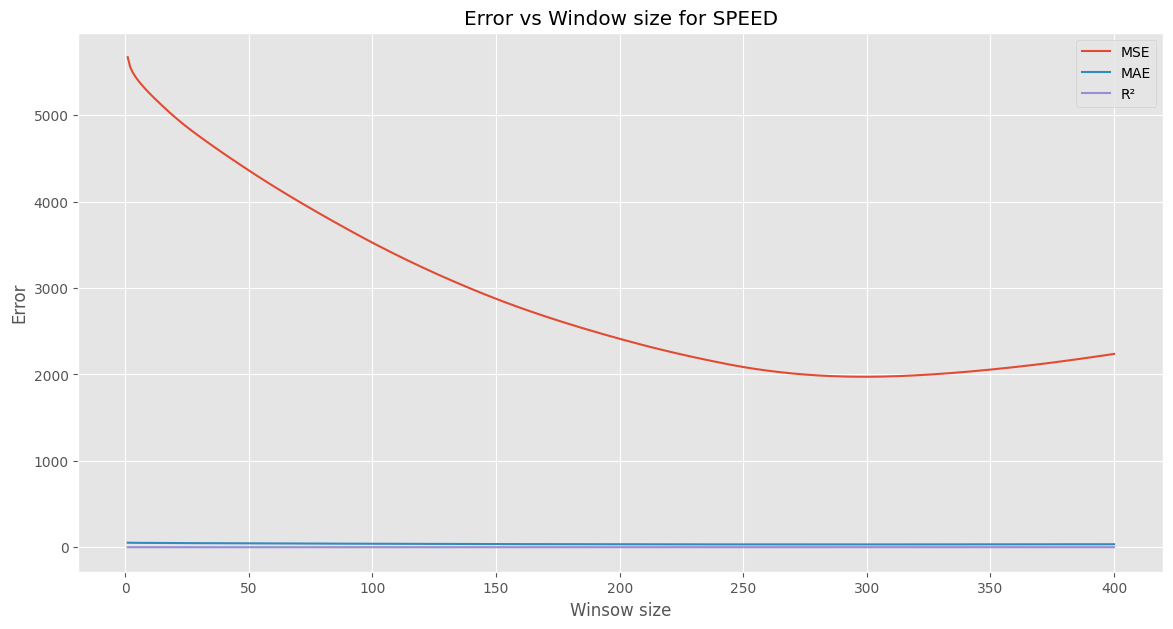

In [30]:
OPTIMUM_moving_filter(2003,"SPEED",400)

In [ ]:
OPTIMUM_moving_filter(2003,"Np",500)

In [ ]:
OPTIMUM_moving_filter(2003,"N/S",500)

In [ ]:
OPTIMUM_moving_filter(2008,"SPEED",500)
OPTIMUM_moving_filter(2008,"Np",500)
OPTIMUM_moving_filter(2008,"N/S",500)

In [ ]:
OPTIMUM_moving_filter(2013,"SPEED",500)
OPTIMUM_moving_filter(2013,"Np",500)
OPTIMUM_moving_filter(2013,"N/S",500)

In [ ]:
OPTIMUM_moving_filter(2018,"SPEED",500)
OPTIMUM_moving_filter(2018,"Np",500)
OPTIMUM_moving_filter(2018,"N/S",500)


In [ ]:
OPTIMUM_moving_filter(2023,"SPEED",20000)

In [ ]:
OPTIMUM_moving_filter(2023,"SPEED",2000)
OPTIMUM_moving_filter(2023,"Np",200)
OPTIMUM_moving_filter(2023,"N/S",200)

In [97]:
def moving_filter(year,column, window_size): ## Rememeber to chabge the names of data sheet and calibreated data

  data_sheet = Raw_data[year]
  calibrated_sheet = Calibrated_data[year]
  column1 = data_sheet[column]            # We have to change the names of "data_sheet" and "Calibrated_data", thus names are for other dataframes
  column2 = calibrated_sheet[column]


  moving_filter = data_sheet[f"{column} Movil_mean"] = column1.rolling(window = window_size).mean() #.rolling allow us to calculate acumulative statistics on a dynamic window

  #Plot
  x1 =  data_sheet['Seconds']
  x2 = calibrated_sheet['Seconds']

  #y axes
  y1 = moving_filter
  y2 = column2
  y3 = column1

  plt.figure(figsize=(26, 10))
  plt.plot(x1,y3, label = f"Raw {column}", color = "blue", linewidth = 0.5, alpha = 0.5 )
  plt.plot(x1,y1, label = f"{column} with movil mean", color = "red", linewidth = 0.8, alpha = 0.9 )
  plt.plot(x2,y2, label = f"Calibrated {column}", color = "green",linewidth = 0.5,alpha = 0.7)
  plt.title(f"Comparisons of {column} with moving mean filter")
  plt.legend()
  plt.grid(True)

  plt.show()

#### 1998 Moving Mean Filter

In [ ]:
moving_filter(1998,"SPEED",10)

In [ ]:
moving_filter(1998,"N/S",30)

In [ ]:
moving_filter(2003,"Np",306)

#### 2000 Moving Mean Filter

In [ ]:
data_2000 = Raw_data[2000]
data_2000.describe()

In [ ]:
plots("N/S",data_2000)

In [ ]:
plots("SPEED",data_2000)

In [ ]:
plots("Np",data_2000)

In [ ]:
moving_filter(2000,"Vth",100)

In [ ]:
moving_filter(2000,"SPEED",100)

In [ ]:
moving_filter(2000,"V_He",100)

In [ ]:
moving_filter(2000,"N/S",30)

In [ ]:
moving_filter(2000,"Np",30)

#### 2003 Moving Mean Filter

In [ ]:
moving_filter(2003,"SPEED",295)

In [ ]:
moving_filter(2003,"V_He",100)

In [ ]:
moving_filter(2003,"N/S",289)

In [ ]:
moving_filter(2003,"Np",306)

#### 2008 Moving mean Filter

In [ ]:
moving_filter(2008,"SPEED",128)

In [ ]:
moving_filter(2008,"V_He",100)

In [ ]:
moving_filter(2008,"N/S",141)

In [ ]:
moving_filter(2008,"Np",173)

#### 2013 Moving mean filter

In [ ]:
moving_filter(2013,"SPEED",78)

In [ ]:
moving_filter(2013,"V_He",100)

In [ ]:
moving_filter(2013,"N/S",82)

In [ ]:
moving_filter(2013,"Np",81)

#### 2018 Moving filter

In [ ]:
moving_filter(2018,"SPEED",14)

In [ ]:
moving_filter(2018,"V_He",100)

In [ ]:
moving_filter(2018,"N/S",17)

In [ ]:
moving_filter(2018,"Np",16)

#### 2023 Moving filter

In [21]:
moving_filter(2023,"SPEED",100)

NameError: name 'moving_filter' is not defined

In [ ]:
moving_filter(2023,"V_He",100)

In [ ]:
moving_filter(2023,"N/S",106)

In [ ]:
moving_filter(2023,"Np",95)

### Fourier Filter

In [130]:
def fourier_low_pass_fiter(year,column,CT_FREQ):

  data_sheet = Raw_data[year]
  calibrated_sheet = Calibrated_data[year]
  calibrated_list = calibrated_sheet[column].tolist()

  #with the column, we convert the data column to a list with .tolist
  data_list = data_sheet[column].tolist()
  # after, we set the frecuency and period of the intervals of time in wich  our data was taken
  T = 30  # Period in seconds
  f_time = 1 / T #frequency of data
  #n = T * np.arange(0, len(direction)) #IDK what this is for
  #Error lists
  mse_errors = []
  mae_errors = []
  r2_scores = []

  # Performing the FFT
  fourier = fftpack.fft(data_list)
  amplitude = abs(fourier) #Here we get from the complex values of the transform its magnitude

  F_vector = f_time * np.arange(0,len(data_list)) / len(data_list) # frequency vector that has various frenquency values that are separated equidistant and has the sime lenght that the transforn

  # Plotting the FFT (frequency vs amplitude) to get the principal frequencies of our data
  plt.figure(figsize=(12, 6))
  plt.plot(F_vector, amplitude)
  plt.title('Frecuencia vs Amplitud')
  plt.xlabel('Frecuencia (Hz)')
  plt.ylabel('Amplitud')
  plt.grid(True)
  plt.show()

  F_start = 0
  F_end = 0.05
  F_step = 0.000001

  filter = np.where(F_vector <= CT_FREQ, 1, 0) # Here we make a matrix wich has the lenght of the total amount of data that we have, and its composed by the frequencies that are below the cutoff frequency,
    #This is by assignign 1 to the Frequencies below cut off and 0 to the frequencies above
  Fourier_with_filter = filter*fourier # here we multiply the fourier transform with the filter, so the 1 values from the matriz now are changed and take the values of the fourier transform
  New_signal = abs(fftpack.ifft(Fourier_with_filter)) # we perform the IFFT to get the new data that is procesed

  #Inserting data on the data frame
  Fourier_data = (New_signal)
  data_sheet.insert(17, f"{column} Fourier Filter",Fourier_data)

  #Plotting new data


  x1 = data_sheet["Seconds"]
  x2 = calibrated_sheet["Seconds"]
  y1 = Fourier_data
  y2 = calibrated_sheet[column]
  y3 = data_list

  plt.figure(figsize = (26,10))
  plt.plot(x1,y1, color = "blue", linewidth = 0.7, label  ="Signal with filter")
  plt.plot(x2,y2, color = "green", linewidth = 0.7, alpha = 0.5, label = "Calibrated data")
  plt.plot(x1,y3, color = "red", linewidth = 0.5, label  ="Raw data", alpha = 0.5)

  plt.xlabel("Time")
  plt.ylabel(column)
  plt.grid(True)
  plt.legend()
  plt.show()

#### 2003 Fourier filter

In [ ]:
fourier_low_pass_fiter(2003,"SPEED",0.003)

In [ ]:
fourier_low_pass_fiter(2003,"Np",0.002)
fourier_low_pass_fiter(2003,"N/S",0.0016)

#### 2008 Fourier filter

In [ ]:
fourier_low_pass_fiter(2008,"SPEED",0.003)

In [ ]:
fourier_low_pass_fiter(2008,"Np",0.002)

In [ ]:
fourier_low_pass_fiter(2008,"N/S",0.0016)

#### 2013 Fourier filter

In [ ]:
fourier_low_pass_fiter(2013,"SPEED",0.003)

In [ ]:
fourier_low_pass_fiter(2013,"Np",0.002)


In [ ]:
fourier_low_pass_fiter(2013,"N/S",0.0016)


#### 2018 Fourier filter

In [ ]:
fourier_low_pass_fiter(2018,"SPEED",0.003)

In [ ]:
fourier_low_pass_fiter(2018,"N/S",0.0016)


In [ ]:
fourier_low_pass_fiter(2018,"Np",0.002)

#### 2023 Fourier filter

In [ ]:
fourier_low_pass_fiter(2023,"SPEED",0.003)


In [ ]:
fourier_low_pass_fiter(2023,"N/S",0.0016)


In [ ]:
fourier_low_pass_fiter(2023,"Np",0.002)

### Median FFT Filter

In [22]:
def MedianFFT(year): ## Rememeber to change the names of data sheet and calibreated data

  data_sheet = Raw_data[year]
  columns = ["SPEED", "Np", "Vth", "N/S", "V_He"]

  for column in columns:
    #Median Fourier filter
    x = data_sheet['Seconds']
    y = data_sheet[column]
    n = len(data)

    f = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d = x[n-1]/n)


    f_fb = []
    mean = np.sqrt(abs(np.median(f))**2)
    for i in range(0,len(f),1):
      dy = f[i]
      if dy > mean:
        f_fb.append(dy)
      else:
        f_fb.append(0)

    tf_f = np.sqrt(abs(np.fft.ifft(f_fb))**2)

    tf_fb = []
    tf_max = np.median(tf_f) + np.min(tf_f)
    for i in range(0,len(tf_f),1):
      dy = tf_f[i]
      if abs(dy) <= tf_max:
        tf_fb.append(dy)
      else:
        tf_fb.append(tf_max)

    data_sheet.insert(19,f"{column} Median FFT",tf_fb) # Insert to dataframe




In [146]:
for year in years:
  MedianFFT(year)

## **Filter comparisons**

### Error percentage

In [147]:
def error(year, column, fourier_col, moving_col, medianfftcol):

  Filter_sheet = Raw_data[year]
  ESA_data = Calibrated_data[year]
  epsilon = 0.0001


  fourier_data = Filter_sheet[fourier_col]
  moving_data = Filter_sheet[moving_col]
  medianfft = Filter_sheet[medianfftcol]
  cal_data = ESA_data[column]
  time = ESA_data["Seconds"]
  Percentage_error1 = []
  Percentage_error2 = []
  error_3 = []
  time_values = []

  for i in range(0,10000,1):
    x= time[i]
    time_values.append(x)


    error_percent1 = ((abs(fourier_data[10*i] - cal_data[i])) / (cal_data[i] + epsilon)) * 100
    Percentage_error1.append(error_percent1)

    error_percent2 = ((abs(moving_data[10*i] - cal_data[i])) / (cal_data[i] + epsilon)) * 100
    Percentage_error2.append(error_percent2)

    error_percent3 = ((abs(medianfft[10*i] - cal_data[i])) / (cal_data[i] + epsilon)) * 100
    error_3.append(error_percent3)

  plt.figure(figsize= (14,8))
  plt.scatter(time_values , y =Percentage_error1, color = "blue", s = 2, label = f"Percentage error for {fourier_col}")
  plt.scatter(time_values  , y = Percentage_error2, color = "orange", s = 2, label = f"Percentage error for {moving_col}")
  plt.scatter(time_values  , y = error_3, color = "purple", s = 2, label = f"Percentage error for {medianfftcol}")
  plt.title(f"Percentage error for fourier and moving filters")
  plt.ylim(0,100)
  plt.xlabel("time")
  plt.ylabel("Error ")
  plt.legend()
  plt.grid(True)
  plt.show()



In [148]:
def error_abs(year, column, fourier_col, moving_col, medianfftcol):

  Filter_sheet = Raw_data[year]
  ESA_data = Calibrated_data[year]

  fourier_data = Filter_sheet[fourier_col]
  moving_data = Filter_sheet[moving_col]
  medianfft = Filter_sheet[medianfftcol]
  cal_data = ESA_data[column]
  time = ESA_data["Seconds"]
  Percentage_error1 = []
  Percentage_error2 = []
  error_3 = []
  time_values = []

  for i in range(0,10000,1):
    x= time[i]
    time_values.append(x)


    error_percent1 = (abs(fourier_data[10*i] - cal_data[i]))
    Percentage_error1.append(error_percent1)

    error_percent2 = (abs(moving_data[10*i] - cal_data[i]))
    Percentage_error2.append(error_percent2)

    error_percent3 = (abs(medianfft[10*i] - cal_data[i]))
    error_3.append(error_percent3)

  plt.figure(figsize= (14,8))
  plt.scatter(time_values , y =Percentage_error1, color = "blue", s = 2, label = f"Absolute error for {fourier_col}")
  plt.scatter(time_values  , y = Percentage_error2, color = "orange", s = 2, label = f"Absolute error for {moving_col}")
  plt.scatter(time_values  , y = error_3, color = "purple", s = 2, label = f"Absolute error for {medianfftcol}", alpha = 0.5)
  plt.title(f"Absolute error for fourier and moving filters")
  plt.ylim(0,40)
  plt.xlabel("time")
  plt.ylabel("Error ")
  plt.legend()
  plt.grid(True)
  plt.show()


In [149]:
# The other function doesnt work well for NS and Np
def mean_error(year, column, fourier_col, moving_col,medianfftcol):

  Filter_sheet = Raw_data[year]
  ESA_data = Calibrated_data[year]


  fourier_data = Filter_sheet[fourier_col]
  moving_data = Filter_sheet[moving_col]
  medianFcol = Filter_sheet[medianfftcol]
  cal_data = ESA_data[column]


  error_percent1 = (abs(np.mean(fourier_data) - np.mean(cal_data))) #/ (np.mean(cal_data))) * 100

  error_percent2 = (abs(np.mean(moving_data) - np.mean(cal_data))) #/ (np.mean(cal_data)) * 100

  error_percent3 = (abs(np.mean(medianFcol) - np.mean(cal_data)))
  return error_percent1, error_percent2, error_percent3

#### 2003 error

In [ ]:
error(2003,"SPEED","SPEED Fourier Filter","SPEED Movil_mean","SPEED Median FFT")

In [ ]:
error_abs(2003,"Np","Np Fourier Filter","Np Movil_mean","Np Median FFT")

In [ ]:
error_abs(2003,"N/S","N/S Fourier Filter","N/S Movil_mean", "N/S Median FFT")

In [ ]:
mean_error(2003,"Np","Np Fourier Filter","Np Movil_mean", "Np Median FFT")

In [ ]:
mean_error(2003,"N/S","N/S Fourier Filter","N/S Movil_mean", "N/S Median FFT")

In [ ]:
mean_error(2003,"SPEED","SPEED Fourier Filter","SPEED Movil_mean", "SPEED Median FFT")

#### 2008 error

In [ ]:
error(2008,"SPEED","SPEED Fourier Filter","SPEED Movil_mean", "SPEED Median FFT")

In [ ]:
error_abs(2008,"Np","Np Fourier Filter","Np Movil_mean", "Np Median FFT")

In [ ]:
error_abs(2008,"N/S","N/S Fourier Filter","N/S Movil_mean", "N/S Median FFT")

#### 2013 **error**

In [ ]:
error(2013,"SPEED","SPEED Fourier Filter","SPEED Movil_mean", "SPEED Median FFT")

In [ ]:
error_abs(2013,"Np","Np Fourier Filter","Np Movil_mean", "Np Median FFT")

In [ ]:
error(2013,"N/S","N/S Fourier Filter","N/S Movil_mean")

In [ ]:
mean_error(2013,"Np","Np Fourier Filter","Np Movil_mean")

In [ ]:
mean_error(2013,"N/S","N/S Fourier Filter","N/S Movil_mean")

#### 2018 error

In [ ]:
error(2018,"SPEED","SPEED Fourier Filter","SPEED Movil_mean")

In [ ]:
error(2018,"V_He", "V_He","V_He Movil_mean")

In [ ]:
error(2018,"Np","Np Fourier Filter","Np Movil_mean")

In [ ]:
error(2018,"N/S","N/S Fourier Filter","N/S Movil_mean")

In [ ]:
mean_error(2018,"Np","Np Fourier Filter","Np Movil_mean")

In [ ]:
mean_error(2018,"N/S","N/S Fourier Filter","N/S Movil_mean")

#### 2023 error

In [ ]:
error(2023,"SPEED","SPEED Fourier Filter","SPEED Movil_mean", "SPEED Median FFT")

In [ ]:
error_abs(2023,"Np","Np Fourier Filter","Np Movil_mean", "Np Median FFT")

In [ ]:
error_abs(2003,"N/S","Np Fourier Filter","N/S Movil_mean", "N/S Median FFT")

In [ ]:
mean_error(2023,"Np","Np Fourier Filter","Np Movil_mean","Np Median FFT")

In [ ]:
mean_error(2023,"N/S","N/S Fourier Filter","N/S Movil_mean")

## **Calculo momento lineal**


In [ ]:
"""
suposiciones:
- los protondes son masas puntuales
  no hay interacciones internas entre ellos
-
"""

In [ ]:
"""
Parametros:
m = masa proton = 1.67262192369 * 10**-27 kg
velocidad = "SPEED"
Factor lorentz = fl
direccion = "N/S"


No es tan facil como decir que momento lineal y ya XD
Parece que tenemos mas de una ecuacion/metodo para hallar la aceleracion que produce el viento solar

toca tener en cuenta el voltaje de la malla, o cuerda de la vela

Se encontraron dos metodos para hallar la aceleracion proporcionada a una vela electrica

"""

In [ ]:
data

In [ ]:
Calibrated_data[2023]

In [170]:
def DeltaV(year):
  """

  Lineal momentum
  p_i = p_f
    m_p*v_p_i + m_s*v_s_i = m_p*v_p_f +  m_s*v_s_f

    dv_s = -(m_p / m_s) * dv_p

    if v_s_i = 0:
      m_p*v_p_i = m_p*v_p_f +  m_s*v_s_f

  Energy
  E_i = E_f
    m_p*(v_p_i**2) + m_s*(v_s_i**2) = m_p*(v_p_f**2) +  m_s*(v_s_f**2)


    if v_s_i = 0:
      m_p*(v_p_i**2) = m_p*(v_p_f**2) +  m_s*(v_s_f**2)

  """

  mp = 1.6726 * 10**-27 # Proton mas in kilograms
  mv = 100 ## Sail mas in kilograms
  vv = 0 #Sail velocity in m/s
  vp = Calibrated_data[year]["SPEED"]
  dp = Calibrated_data[year]["Np"]
  theta = Calibrated_data[year]["N/S"]
  sec = Calibrated_data[year]["Seconds"]
  dvf=[]
  dv=[]
  vf= 0
  for i in range(0,len(vp),1):
    v =2*((1000 * vp[i] * np.cos(theta[i] * np.pi/180) * dp[i]*100**3 *(sec[i]-sec[0]))-vv)/(1+(mv/mp)) #*dp[i]*(sec[i]-sec[0])
    vf += v
    dv.append(v)
    dvf.append(vf)


  def ec(x, a, b):
    return a*x +b#a + (b**((c*x) + d))


  param, cov = curve_fit(ec, sec, dvf)

  incert = np.sqrt(np.diag(cov))

  print(param)
  print(incert)


  def ec1(x, a, b, c):
    return a + b*x + c*(x**2)#a + (b**((c*x) + d))


  param1, cov1 = curve_fit(ec1, sec, dvf)

  incert1 = np.sqrt(np.diag(cov1))

  print(param1)
  print(incert1)


  def ec2(x, a, b, c):
    return a + b*(x**c)#a + (b**((c*x) + d))


  param2, cov2 = curve_fit(ec2, sec, dvf, p0=[param[0], param[1]*abs(param[0]), 1 + np.emath.logn(abs(sec[len(dvf)-1]), abs(1/param[1]))])

  incert2 = np.sqrt(np.diag(cov2))

  print(param2)
  print(incert2)


  def ec3(x, a, b, c, d, e):
    return a + b*(c**((d*x) + e))#a + (b**((c*x) + d))


  param3, cov3 = curve_fit(ec3, sec, dvf)

  incert3 = np.sqrt(np.diag(cov3))

  print(param3)
  print(incert3)



  def ec1p(x, a, b, c, d, e, f, g):
    return a + b*x + c*(x**2) + d*(x**3) + e*(x**4) + f*(x**5) + g*(x**6) #a + (b**((c*x) + d))


  param1p, cov1p = curve_fit(ec1p, sec, dvf, p0=(param1[1],param1[2],0,0,0,0,0), maxfev=10000)

  incert1p = np.sqrt(np.diag(cov1p))

  print(param1p)
  print(incert1p)



  plt.scatter(sec, dvf, color="#3366FF", s=1)
  plt.scatter(sec, ec(sec, *param), color="red", s=1)
  plt.scatter(sec, ec1(sec, *param1), color="red", s=1)
  #plt.scatter(sec, ec2(sec, *param2), color="red", s=1)
  #plt.scatter(sec, ec3(sec, *param3), color="red", s=1)
  plt.scatter(sec, ec1p(sec, *param1p), color="red", s=1)
  plt.ylim(-1e-5,1e-4)
  plt.ylabel(f"Delta V (m/s) {year}")
  plt.xlabel("Seconds (s)")
  plt.title("Delta V")
  plt.show()






In [ ]:
for year in years:
  DeltaV(year)

## **Aceleración**

In [23]:
#Parameters
# Parámetros
proton_mass = 1.672621 * 10**-27  # Masa del protón en kilogramos
ro_cobre = 8900  # Densidad de cobre en kg/m^3
permitivity = 8.8541878176 * 10**-12  # Permitividad del vacío
m_He = 5.006412 * 10**-27  # Masa del helión en kg
e = -1.602176634 * 10**-19  # Carga del electrón en Coulomb
r_w = 12.5 * 10**-6 #Wire radius
A = np.pi * r_w**2  # Cross sectional area of the wire
proton_charge = 1.602176634 * 10**-19


k_Hoy= 4.3 #Coefficcient for the Hoytheter structure
K_Hey = 1 #Coefficcient for the Heytheter structure
Beta = 0.25 # Mass to power ratio ()kg/W
n_earth = 7.3 * 10**6 #mean solar wind electrondensity (m^-3)

V = 14.5 * 10**3 #Wire potential(KV)
m_e = 9.109382* 10**-31 #Electron mass (Kg)
ro_al = 4000 #Aluminum density (kg/m^3)
r_earth= 1.497*10**11 #Distance from de sun to arth (m)
r_l1 = 1.4811 * 10**11 #Distance from the sun to lagrange 1
k_b =1.38065 * 10**-23
m_pay =  100 #Payload mass(kg)
#Mass calc
"""  According to:
m_total = m_body+m_tether+m_pay
"""

m_body = 2*k_Hoy*Beta*n_earth*r_w* np.sqrt((2*(proton_charge**3)*(V**3)/m_e)) * 20*10**5

m_tether = k_Hoy * np.pi * r_w**2 * 20*10**3 * ro_al * 100

m_total= m_pay + m_body + m_tether

##Other paramters
n_frac_masspay = m_pay/m_total #Payload mass fraction



In [24]:
print(m_total, m_body, m_tether)


181.9873308647128 65.10127035166768 16.886060513045134


In [38]:
Kinetic_temp = (1/3) *m_e * (400*1000)**2 #Hinetic temperature of plasma y Joules
debye_lenght = np.sqrt((permitivity * 1.92261196*10**(-18)) / (n_earth * e**2)) #This must be the theter spacing

print(f"The kinectic temp is {Kinetic_temp}")
print(f"deby_lenght is {debye_lenght}")

The kinectic temp is 4.858337066666666e-20
deby_lenght is 9.531217081149867


### First method

In [25]:
#from scipy.integrate import trapz,simps


def acceleration_1(year):
    Data = Raw_data[year]

    # Preliminar calc
    alpha = np.radians(Data["N/S Movil_mean"]) # Angle of proton arrival
    V_He = Data["V_He Movil_mean"]*1000 #Helium speed in m/s

    Kinetic_temp = (1/3) * m_He * np.mean(V_He)**2 #Hinetic temperature of plasma y Joules
    debye_lenght = np.sqrt((permitivity * Kinetic_temp) / (n_earth * e**2)) #This must be the theter spacing

    # Calcular densidad de masa del viento solar y componente de velocidad
    ro_sw = Data["Np Movil_mean"] * proton_mass * 100**3
    v = Data["SPEED Movil_mean"] * np.cos(alpha) * 1000 # Component of velocity normal to the sail surface in m/s

    # Calcular aceleración
    acceleration = (ro_sw / (2 * ro_al)) * ((debye_lenght * v**2) / A)

    # Seleccionar solo las filas necesarias
    acceleration_sample = acceleration # We use segmentation tool, it allow us to analize the data faster than a for loop, the first colon indicates that we start from the beginnig, the second one were do we end and lastly the number indicates the pitch
    time_sample = Data["Seconds"]

    if np.isnan(time_sample).any() or np.isnan(acceleration_sample).any():
      mask = ~np.isnan(time_sample) & ~np.isnan(acceleration_sample)
      time_sample =time_sample[mask]
      acceleration_sample = acceleration_sample[mask]

    Thrust = acceleration_sample * m_total #[N]
    Velocity_trap = trapz(acceleration_sample,time_sample)
    Velocity_simp = simps(acceleration_sample,time_sample)

    plt.figure(figsize=(12,8))
    plt.plot(time_sample, acceleration_sample, color = "lightseagreen")
    plt.title("Acceleration")
    plt.xlabel("Seconds")
    plt.ylabel("Acceleration (m/s^2)")
    plt.show()


    print(f"The maximun acceleration for this year was {acceleration_sample.max()} m/s^2")
    print(f"By the trapz method the total velocity is: {Velocity_trap} m/s")
    print(f"By the simpson methon the total velocity is: {Velocity_simp} m/s")
    print(f"The mimimun acceleration in {year} was {np.min(acceleration)}")
    print(debye_lenght)
    print(Kinetic_temp)


In [27]:
acceleration_1(2003)

KeyError: 'N/S Movil_mean'

In [17]:
acceleration_1(2003)

KeyError: 'N/S Movil_mean'

In [ ]:
acceleration_1(2008)

In [ ]:
acceleration_1(2013)

In [ ]:
acceleration_1(2018)

In [ ]:
acceleration_1(2023)


### 2 method

In [42]:

#Characteristic Acceleration

def Acceleration_2(year):

  Data = Calibrated_data[year]
  time_sample = Data["Seconds"]
  #Preliminar calc
  alpha = np.radians(Data["N/S"]) # Angle of proton arrival
  V_He = Data["V_He"]*1000 #Helium speed in m/s
  v = Data["SPEED"] * np.cos(alpha) * 1000 # Component of velocity normal to the sail surface in m/s
  v = np.array(v) 


  #Kinetic_temp = (1/3) * m_e * (v)**2 #Hinetic temperature of plasma y Joules
  Kinetic_temp = 12* proton_charge
  debye_lenght = np.sqrt((permitivity * (Kinetic_temp)) / (n_earth*k_b * proton_charge**2)) #This must be the theter spacing

  #Calcular densidad de masa del viento solar y componente de velocidad


  numerador = (6.18 * (1-n_frac_masspay) * proton_mass * v[0]**2 * np.sqrt((n_earth*permitivity* (Kinetic_temp))/k_b))
  denominador = (proton_charge*(m_body + m_tether)*(np.sqrt(np.exp((proton_mass * v[0]**2)/(proton_charge*V) * np.log((2/r_w) * debye_lenght)) -1)))

 
  a_c_0 = numerador/denominador
  acc = np.zeros(len(v))
  t = 30

  velocity = np.zeros(len(v))
  v_0 = 0
  velocity[0] = v_0
  r = np.zeros(len(v)+1)
  r[0] = r_l1

  for i in range(len(v)-1):
    acc[i] = (a_c_0/2) *(r_earth/r[i])
    velocity[i+1] = acc[i]*(t) + velocity[i]
    r[i+1] = (0.5)*acc[i]*t**2+velocity[i]*t+r[i] 

  n = (6.18 * (1-n_frac_masspay) * proton_mass * v**2 * np.sqrt((n_earth*permitivity* np.mean(Kinetic_temp))/k_b))
  d = (proton_charge*(m_body + m_tether)*(np.sqrt(np.exp((proton_mass * v**2)/(proton_charge*V) * np.log((2/r_w) * debye_lenght)) -1)))

  charac_acc = n/d

#  sail_velocity = trapz(acceleration_2,time_sample)

  plt.figure(figsize=(16,8))
  plt.plot(time_sample, charac_acc, color = "lightseagreen")
  plt.title("Characteristic_accelearation")
  plt.xlabel("Seconds")
  plt.ylabel("Acceleration (m/s^2)")
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(time_sample, acc, color = "darkorchid")
  plt.title("Acceleration method 2")
  plt.xlabel("Seconds")
  plt.ylabel("Acceleration (m/s^2)")
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(time_sample, velocity, color = "blue")
  plt.title("Velocity method 2")
  plt.xlabel("Seconds")
  plt.ylabel("Velocity (m/s)")
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(time_sample, r[:-1], color = "lightsteelblue")
  plt.title("Heliocentric Position method 2")
  plt.xlabel("Seconds")
  plt.ylabel("Acceleration (m/s^2)")
  plt.show()


  print("Values Calculations for method 2")
  print(f"The mean value for the acceleration is {np.mean(acc)} m/s^2")
  print(f"The mimimun acceleration in {year} was {np.min(acc)}")
  print(f"The maximun acceleration in {year} was {np.max(acc)}")
  print(f"The sail velocity Final position was {r[len(v)]} m")
  print(f"The final sail velocity was {velocity[len(v)]} m/s")
  print(f"The mean value for the characteristic acceleration is {np.mean(charac_acc)} m/s^2")

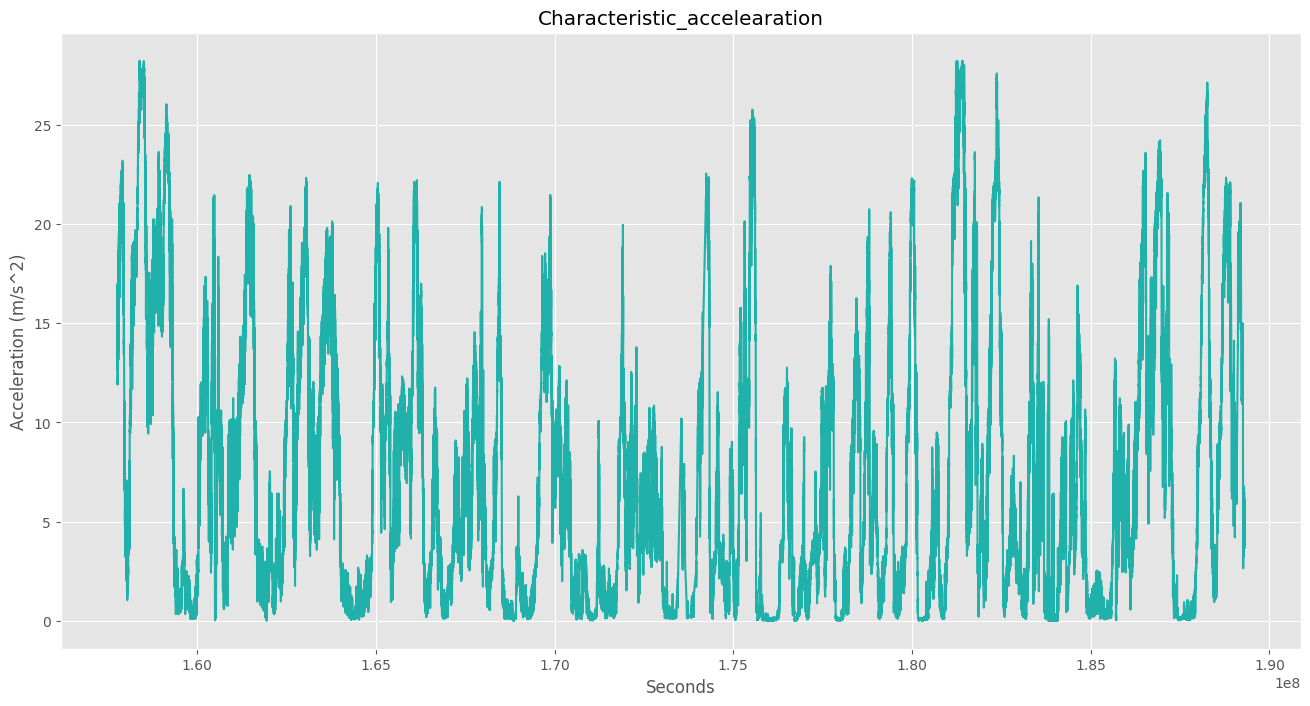

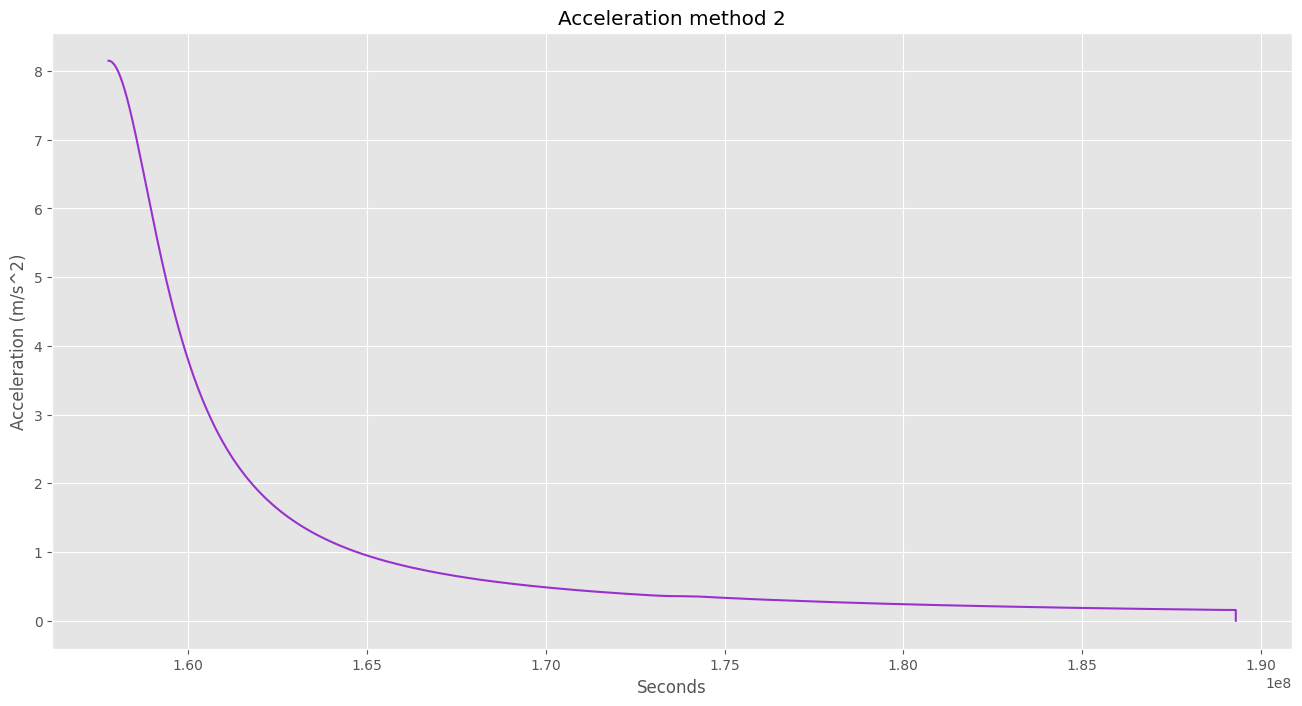

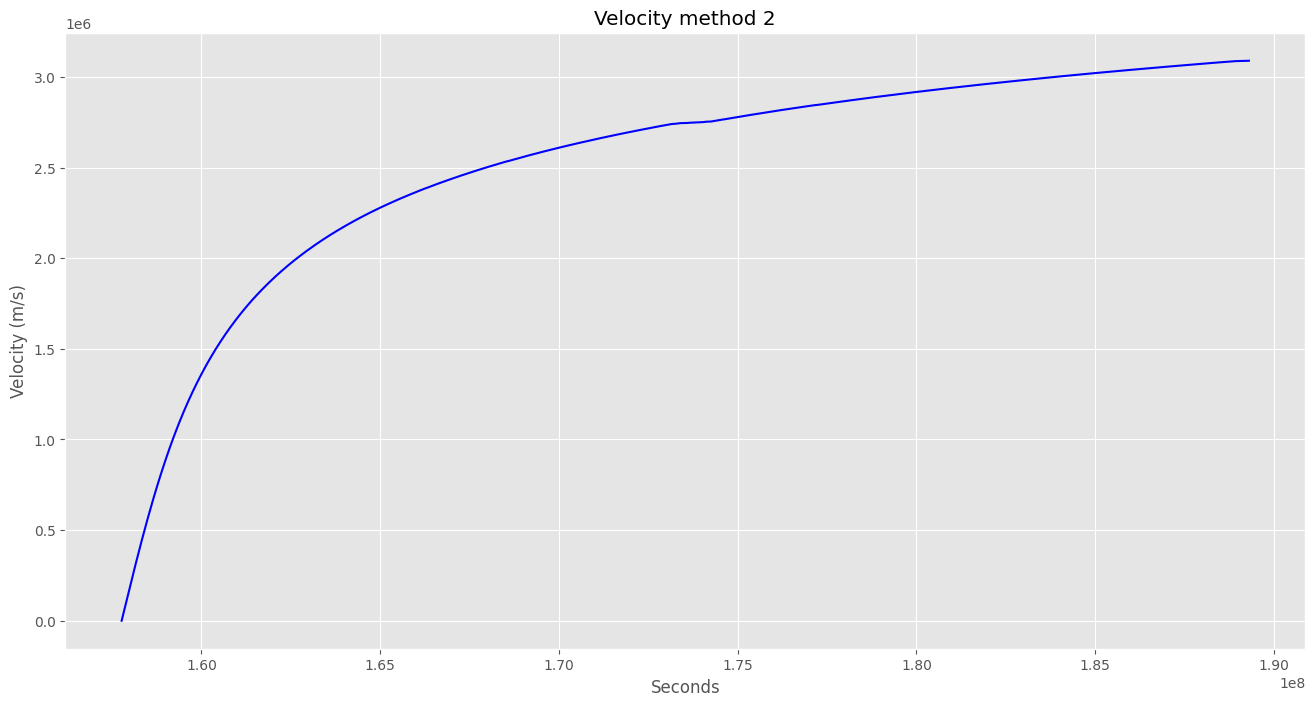

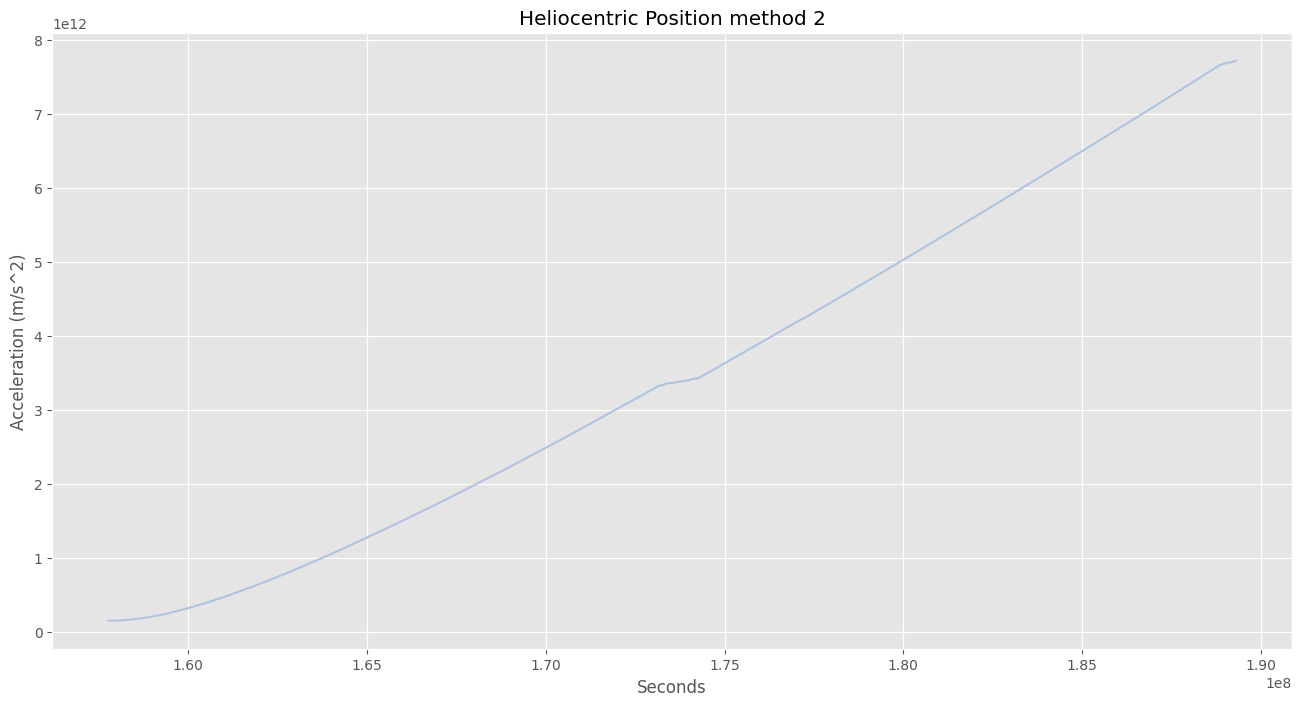

Values Calculations for method 2
The mean value for the acceleration is 1.0235859857239453 m/s^2
The mimimun acceleration in 2003 was 0.0
The maximun acceleration in 2003 was 8.148932964153804
The sail velocity Final position was 0.0 m


IndexError: index 100602 is out of bounds for axis 0 with size 100602

In [43]:
Acceleration_2(2003)


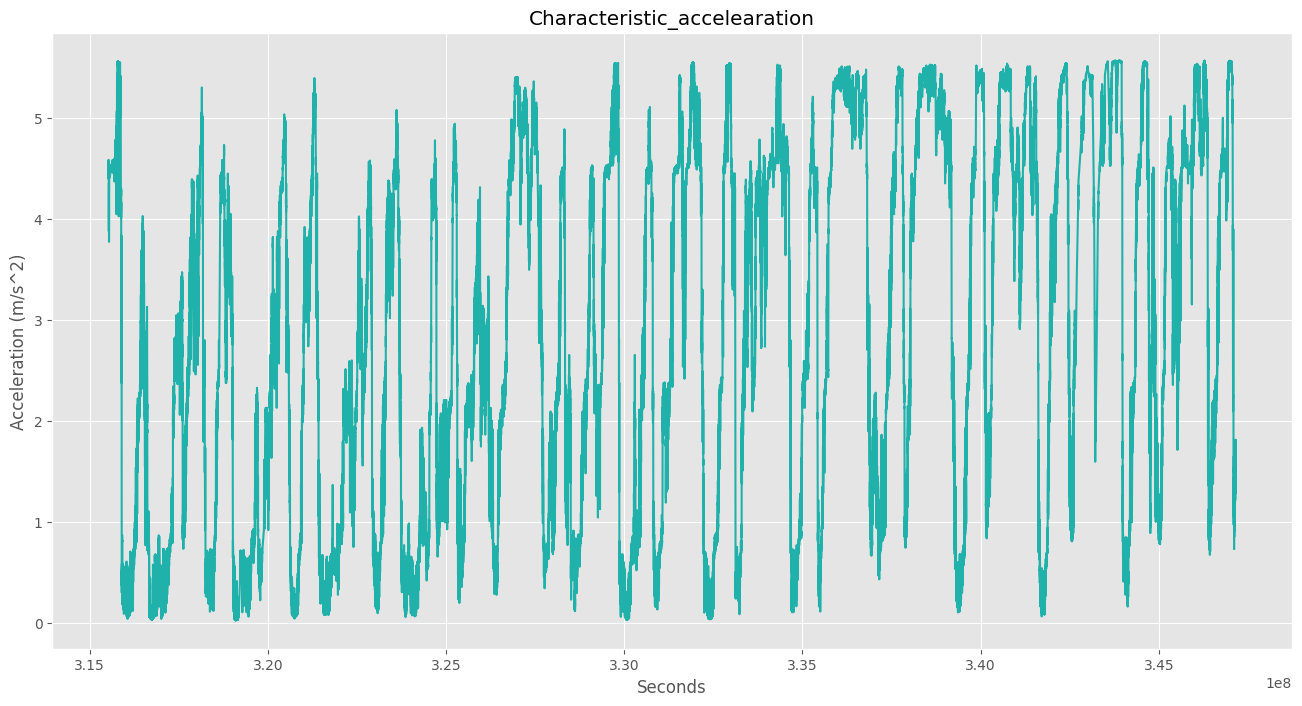

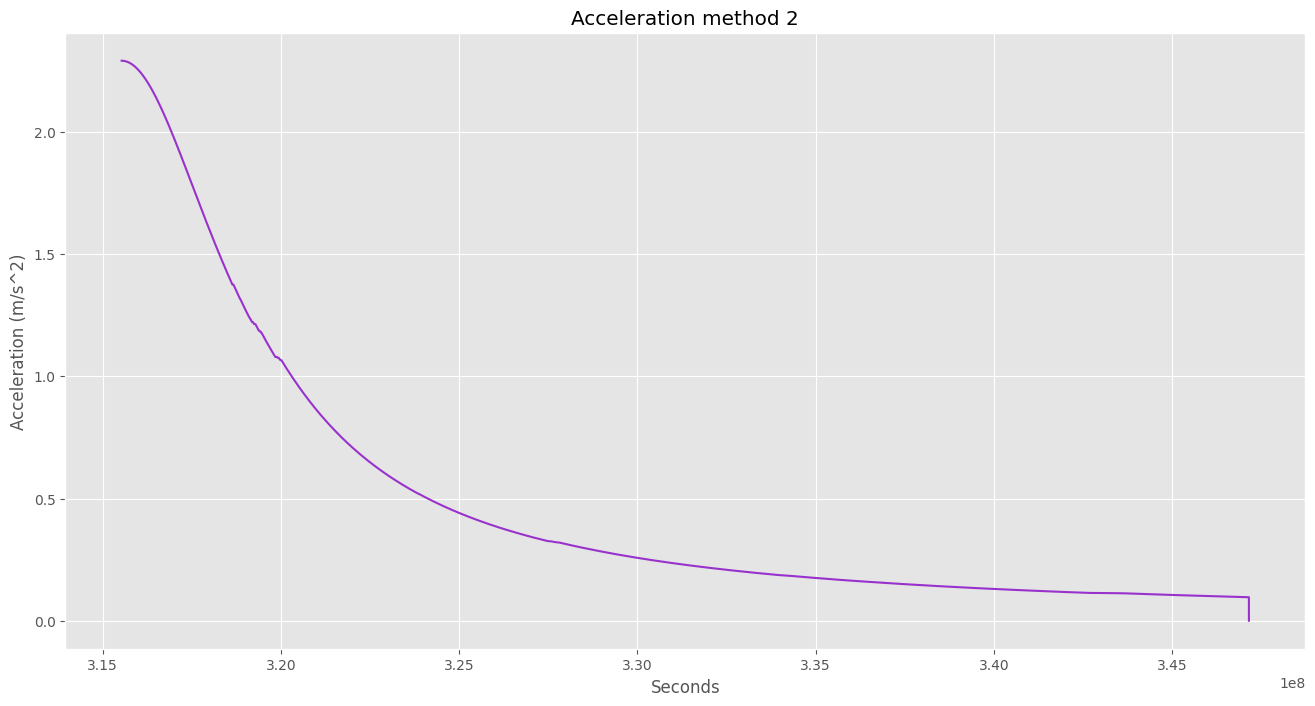

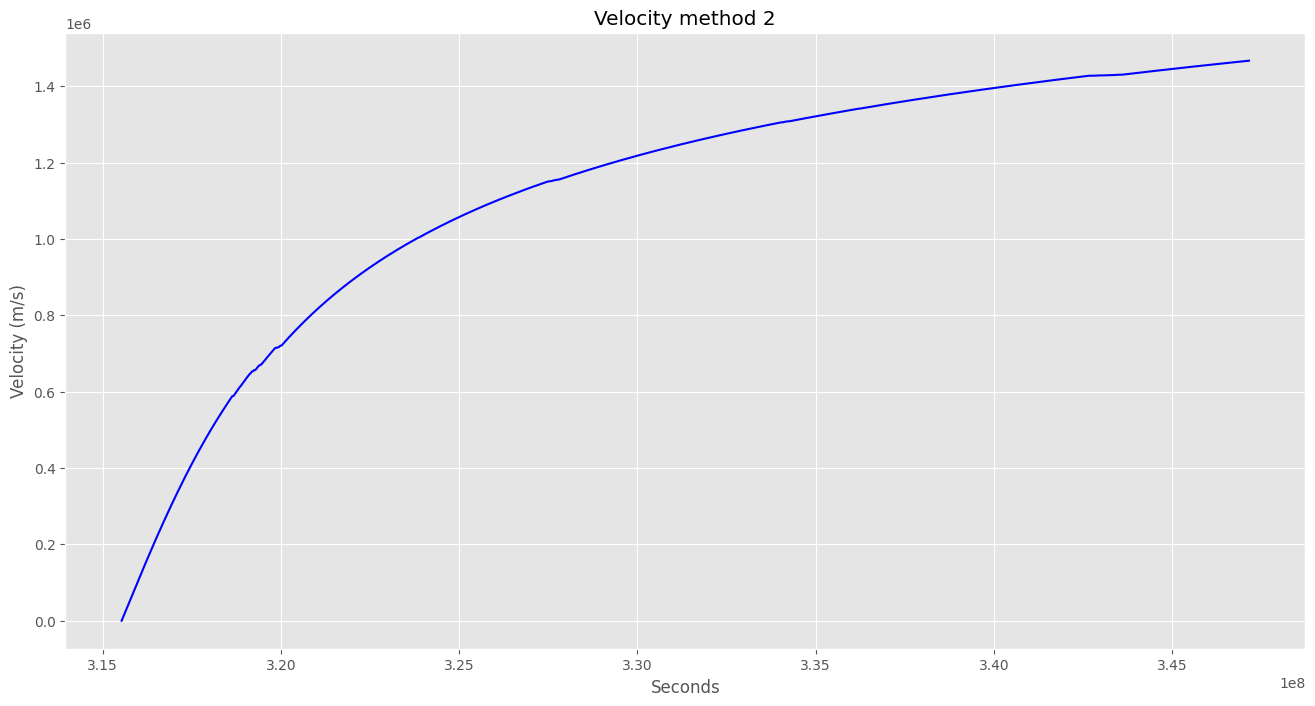

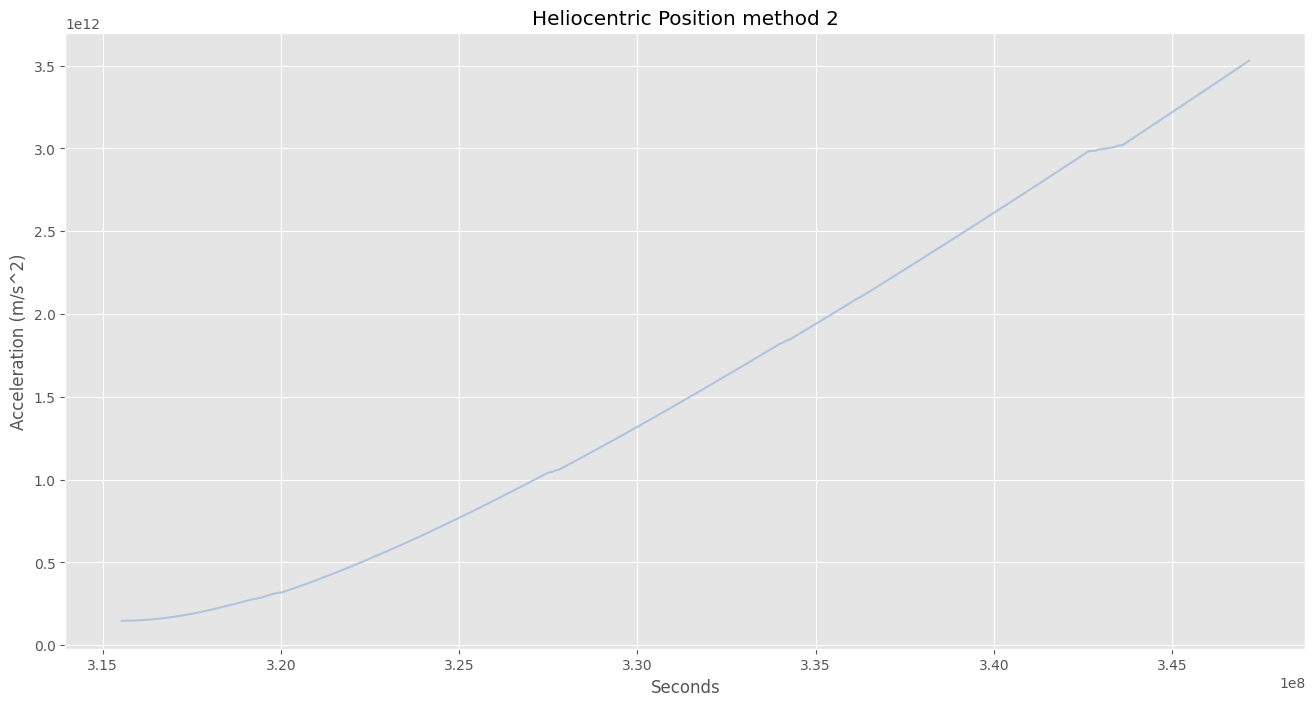

Values Calculations for method 2
The mean value for the acceleration is 0.4869016976427497 m/s^2
The mimimun acceleration in 2008 was 0.0


NameError: name 'a' is not defined

In [27]:
Acceleration_2(2008)

In [ ]:
Acceleration_2(2013)

In [ ]:
Acceleration_2(2018)

In [ ]:
Acceleration_2(2023)

### METHOD 3

In [36]:
def acceleration_3(year):
  Data = Calibrated_data[year]
  time_sample = Data["Seconds"]
  #Preliminar calc
  alpha = np.radians(Data["N/S"]) # Angle of proton arrival
  V_He = Data["V_He"]*1000 #Helium speed in m/s

  Kinetic_temp = (1/3) * m_e * (V_He)**2 #Hinetic temperature of plasma y Joules
 # Kinetic_temp = 12 * proton_charge
  debye_lenght = np.sqrt((permitivity * Kinetic_temp) / (n_earth*k_b * proton_charge**2)) #This must be the theter spacing

  #Calcular densidad de masa del viento solar y componente de velocidad

  v = Data["SPEED"] * np.cos(alpha) * 1000 # Component of velocity normal to the sail surface in m/s
  v = np.array(v)

  V_w = 1 *10**3 #Solar wind elecric potential
  sigma_f = 0.18* (V-V_w)*v[0]*np.sqrt(permitivity*proton_mass*n_earth)
  a_c_0 = (100* 20* 10**3 *sigma_f)/(m_total)


  sail_velocity = np.zeros(len(v))
  sail_velocity[0] = 0
  r = np.zeros(len(v)+1)
  r[0] = r_l1
  acceleration3 = np.zeros(len(v))
  t = 30

  for i in range(len(v)-1):
    acceleration3[i] = a_c_0 * (r_earth/r[i])
    sail_velocity[i+1] = acceleration3[i]*t + sail_velocity[i]
    r[i+1] = (0.5)*acceleration3[i]*t**2 + sail_velocity[i]*t + r[i]

  #Characteristic acc
  sigma_all = 0.18* (V-V_w)*v*np.sqrt(permitivity*proton_mass*n_earth)
  a_c = (100* 20* 10**3 *sigma_all)/(m_total)

#sail_velocity = simps(acceleration,time_sample)


  plt.figure(figsize=(16,8))
  plt.plot(time_sample, a_c, color = "lightseagreen")
  plt.title("Characteristic_accelearation")
  plt.xlabel("Seconds")
  plt.ylabel("Acceleration (m/s^2)")
  plt.show()

  plt.figure(figsize=(14,8))
  plt.plot(time_sample, acceleration3, color = "mediumseagreen")
  plt.title("Acceleation method 3")
  plt.xlabel("Seconds")
  plt.ylabel("Acceleration (m/s^2)")
  plt.show()

  plt.figure(figsize=(14,8))
  plt.plot(time_sample, sail_velocity, color = "chartreuse")
  plt.title("velocity method 3")
  plt.xlabel("Seconds")
  plt.ylabel("Velocity (m/s)")
  plt.show()

  plt.figure(figsize=(14,8))
  plt.plot(time_sample, r[:-1], color = "steelblue")
  plt.title("Heliiocentric radius")
  plt.xlabel("Seconds")
  plt.ylabel("Radius (m)")
  plt.show()

  

  print("Values calculated for method 3")
  print(f"The mean value for the acceleration is {np.mean(acceleration3)} m/s^2")
  print(f"The mimimun acceleration in {year} was {np.min(acceleration3)}  m/s^2 ")
  print(f"The maximun acceleration in {year} was {np.max(acceleration3)}  m/s^2")
  print(f"The final sail velocity was {sail_velocity[-1]} m/s")
  print(f"The mean value for the characteristic acceleration is {np.mean(a_c)} m/s")


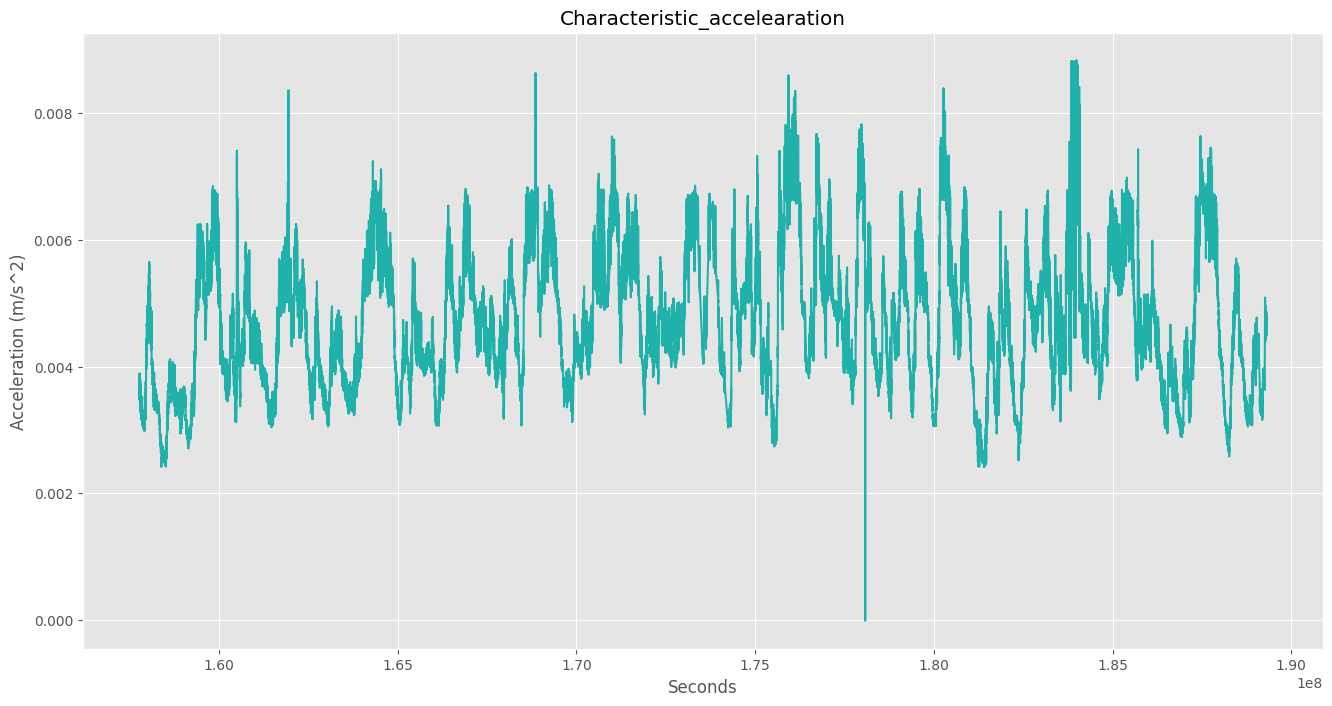

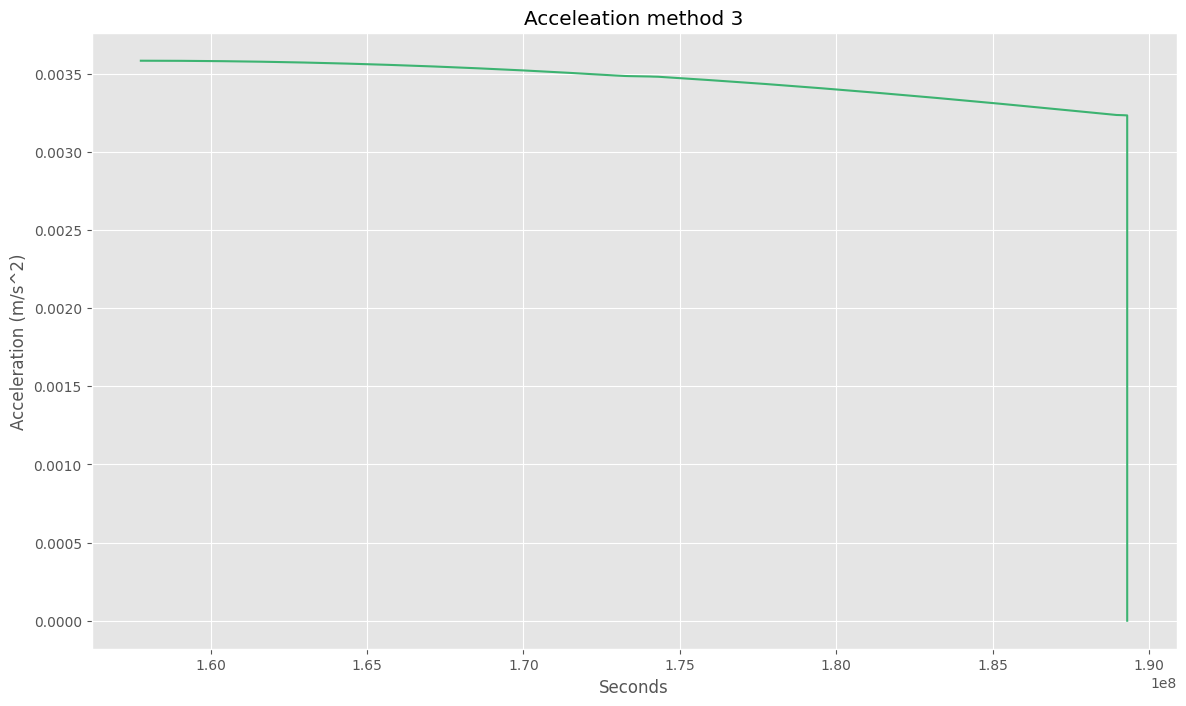

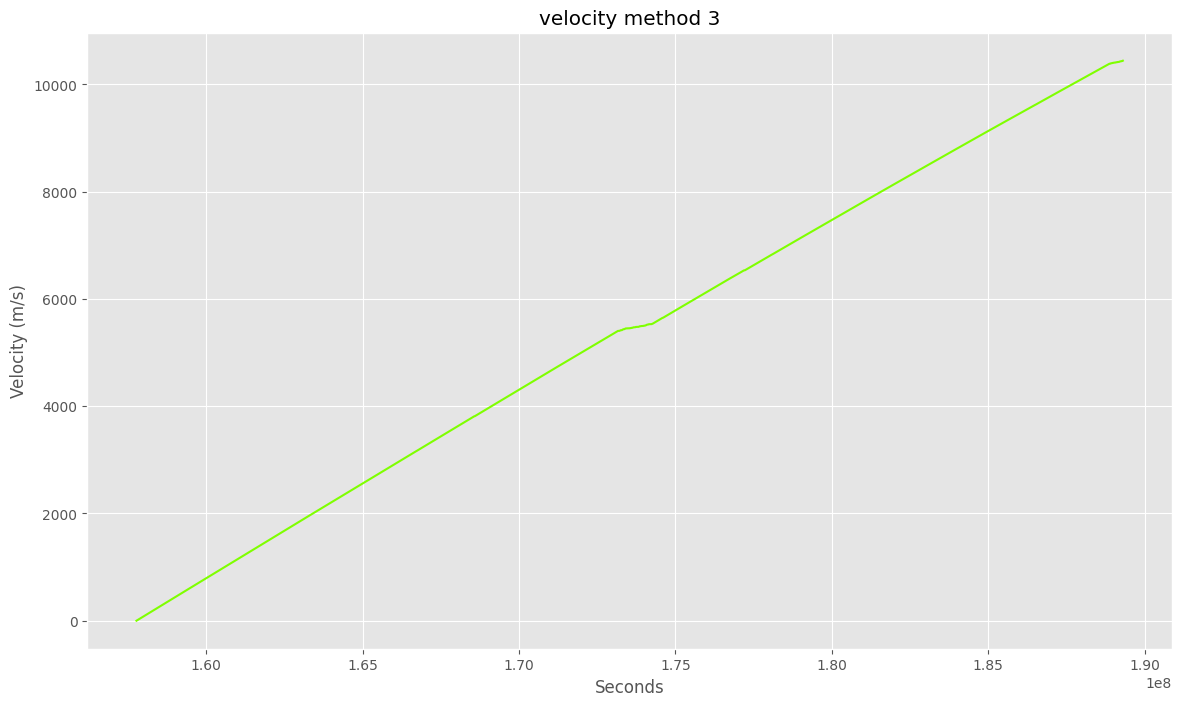

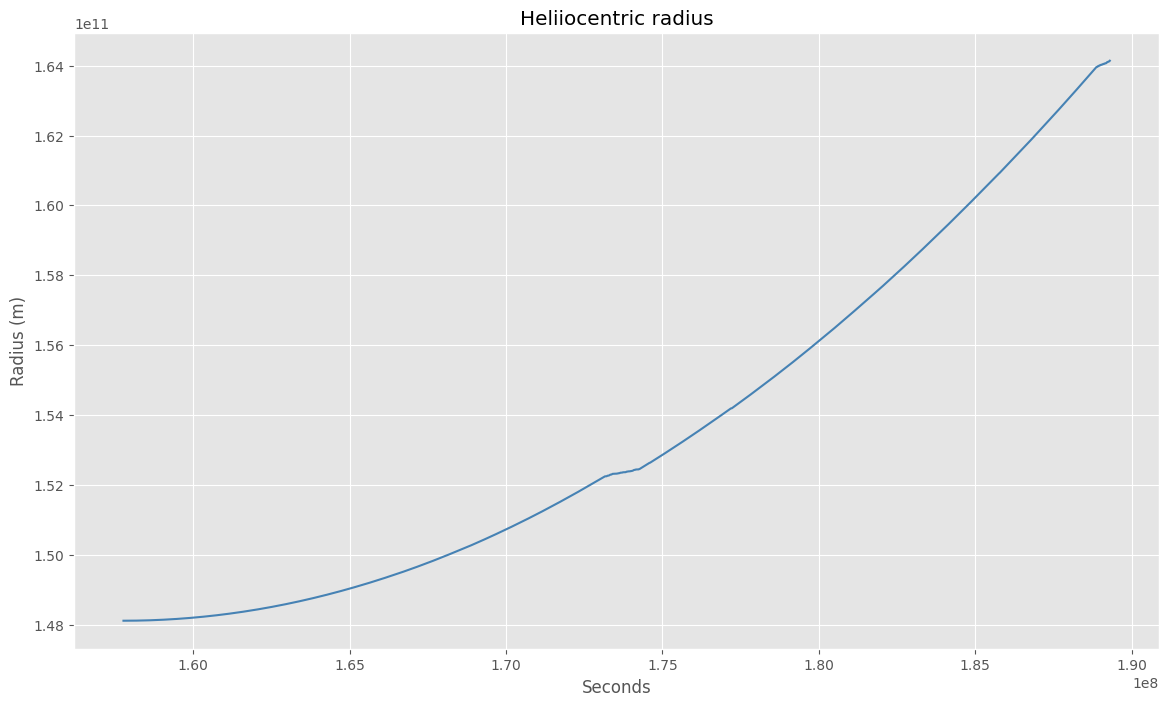

Values calculated for method 3
The mean value for the acceleration is 0.00346028371899117 m/s^2
The mimimun acceleration in 2003 was 0.0  m/s^2 
The maximun acceleration in 2003 was 0.003582601094752453  m/s^2
The final sail velocity was 10443.34388093822 m/s
The mean value for the characteristic acceleration is 0.004720438913611735 m/s


In [37]:
acceleration_3(2003)

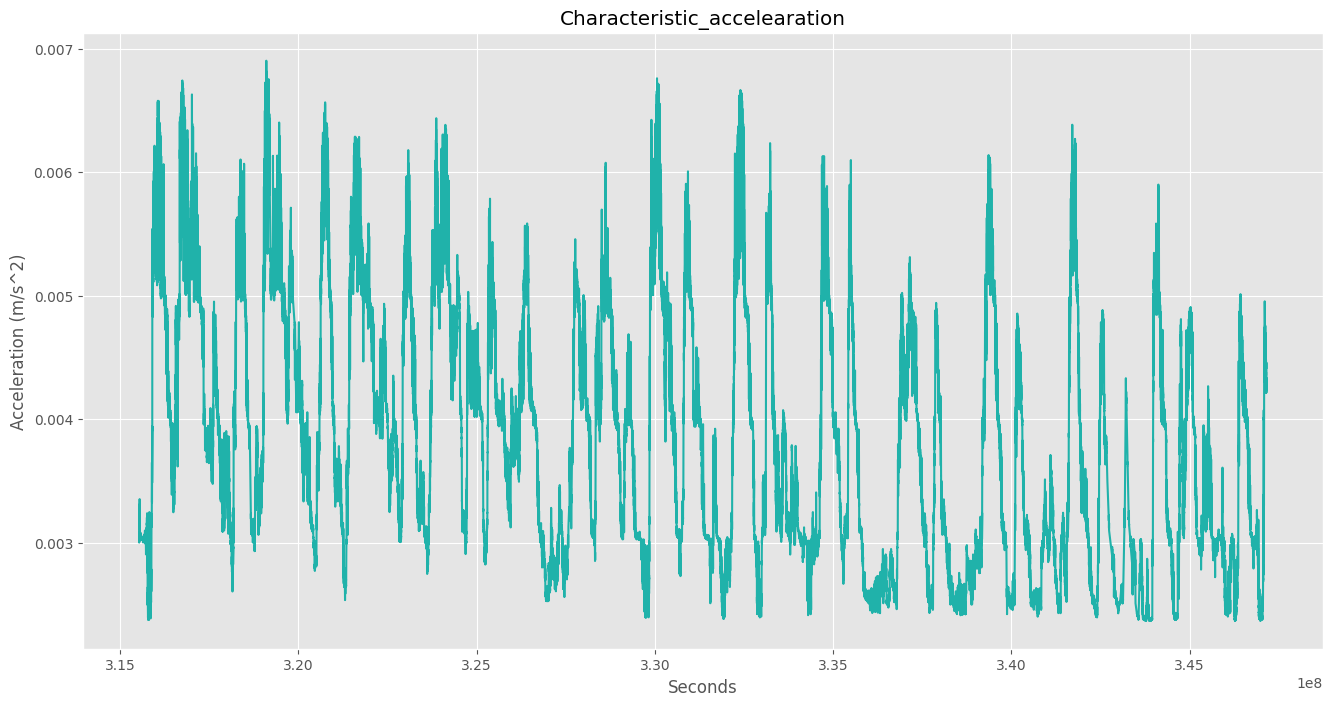

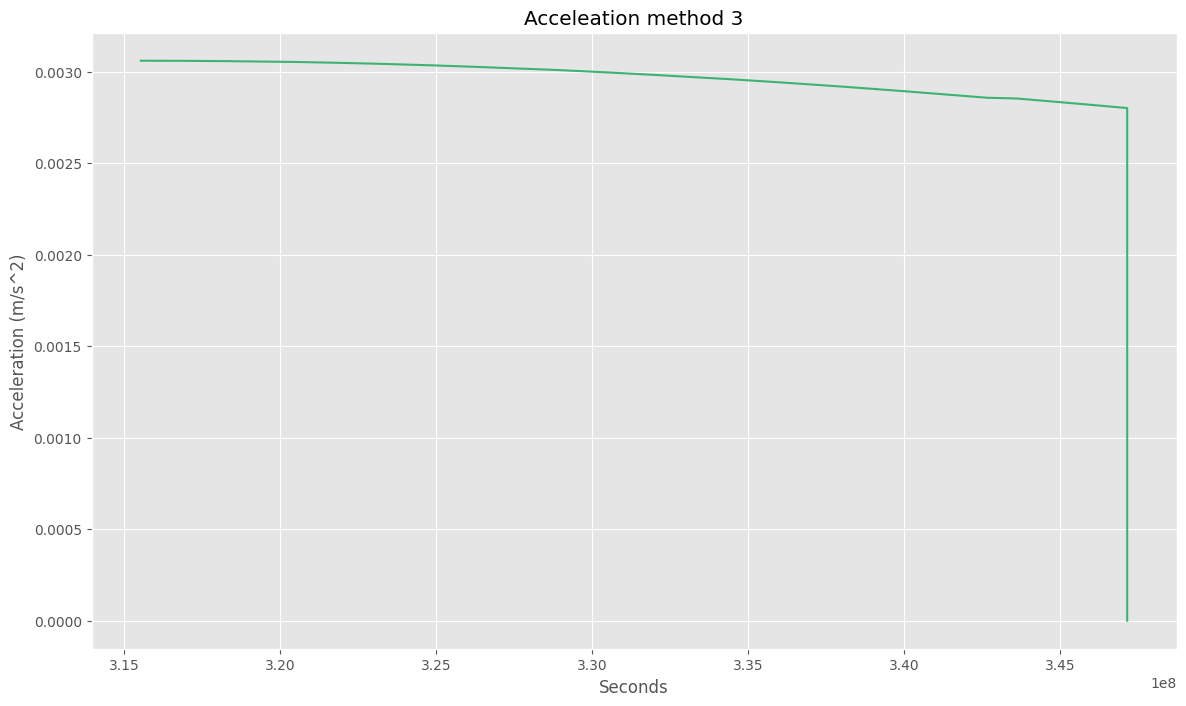

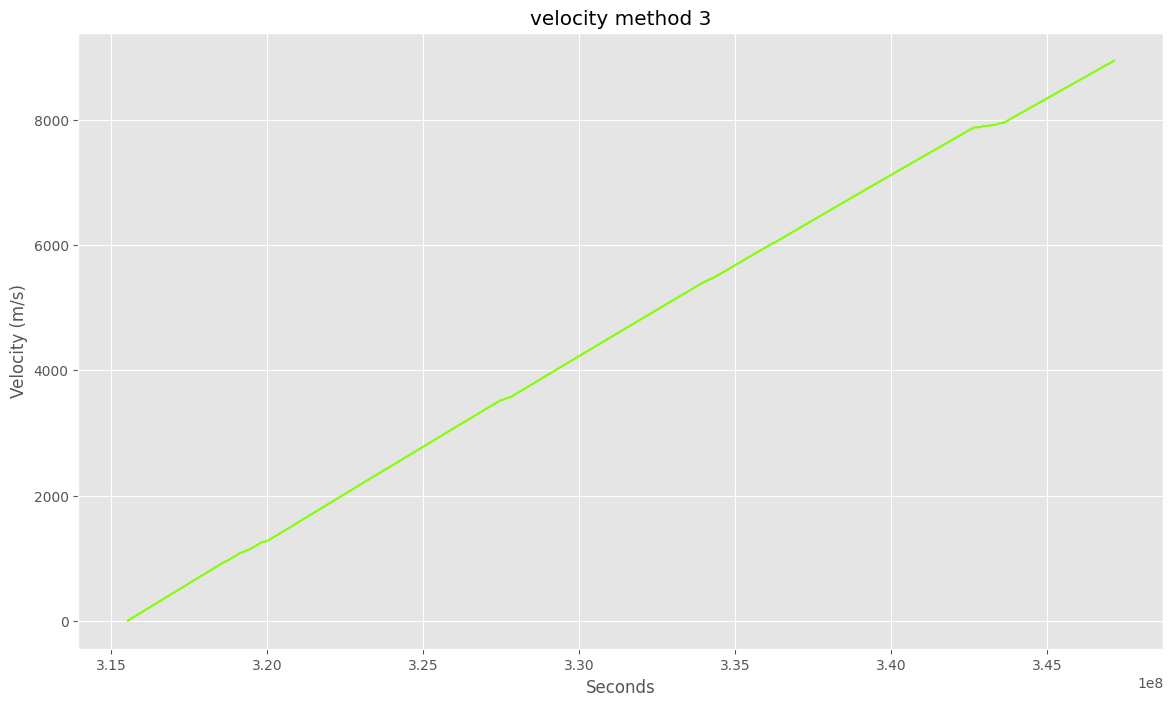

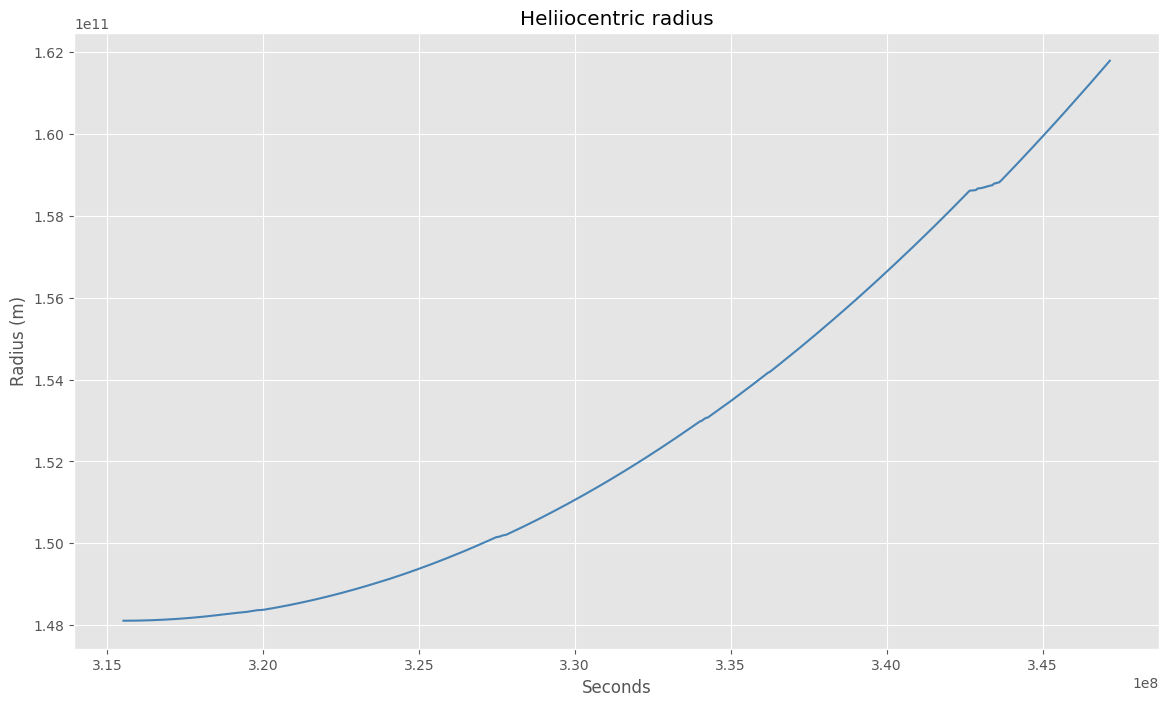

Values calculated for method 3
The mean value for the acceleration is 0.002969141491868658 m/s^2
The mimimun acceleration in 2008 was 0.0  m/s^2 
The maximun acceleration in 2008 was 0.0030589518859419876  m/s^2
The final sail velocity was 8946.08269783017 m/s
The mean value for the characteristic acceleration is 0.003839573718516309 m/s


In [38]:
acceleration_3(2008)

In [ ]:
acceleration_3(2013)

In [ ]:
acceleration_3(2018)

In [ ]:
acceleration_3(2023)